In [ ]:
import os
import numpy as np

def load_eye_tracking_data(folder_path, file_pattern='Waldo_Ruj1.txt', remove_first_n_points=250):
    """
    Load and preprocess eye-tracking data from multiple .txt files in a folder.

    Parameters:
        folder_path (str): Path to the folder containing the .txt files.
        file_pattern (str): File pattern to match specific files (default: 'Waldo_Ruj35.txt').
        remove_first_n_points (int): Number of initial points to remove from each file.

    Returns:
        dict: A dictionary containing lists of cleaned data for time (T), x-coordinates (X),
              y-coordinates (Y), and saccades (saccade).
    """
    # Get list of files matching the pattern
    files = [file for file in os.listdir(folder_path) if file.endswith(file_pattern)]
    if not files:
        raise FileNotFoundError(f"No files found matching the pattern '{file_pattern}' in '{folder_path}'.")

    # Initialize lists to store data
    T, X, Y, saccade = [], [], [], []

    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            # Load data
            data = np.loadtxt(file_path)
            if data.shape[0] > data.shape[1]:
                data = data.T  # Transpose if rows > columns

            # Extract columns
            T_i = data[0]
            X_i = data[1]
            Y_i = data[2]
            saccade_i = data[3]

            # Remove initial points
            T_i = T_i[remove_first_n_points:]
            X_i = X_i[remove_first_n_points:]
            Y_i = Y_i[remove_first_n_points:]
            saccade_i = saccade_i[remove_first_n_points:]

            # Append cleaned data
            T.append(T_i)
            X.append(X_i)
            Y.append(Y_i)
            saccade.append(saccade_i)

        except Exception as e:
            print(f"Error loading {file}: {e}")

    return {
        "T": T,
        "X": X,
        "Y": Y,
        "saccade": saccade
    }

# Example usage:
folder_path = '/home/shailendra/Documents/PhD_Oslomet/QuantumGanWaldo/WALDO/WalDo'
result = load_eye_tracking_data(folder_path)

# Access the processed data
print(f"Number of files processed: {len(result['T'])}")
print("First 5 time values from the first file:", result['T'][0][:5] if result['T'] else "No data")
print("First 5 X values from the first file:", result['X'][0][:5] if result['X'] else "No data")
print("First 5 Y values from the first file:", result['Y'][0][:5] if result['Y'] else "No data")
print("First 5 saccade values from the first file:", result['saccade'][0][:5] if result['saccade'] else "No data")


Number of files processed: 1
First 5 time values from the first file: [1.66544517e+08 1.66544518e+08 1.66544519e+08 1.66544520e+08
 1.66544521e+08]
First 5 X values from the first file: [770.8 770.8 770.8 770.9 771.2]
First 5 Y values from the first file: [910.1 910.3 910.5 911.  911.6]
First 5 saccade values from the first file: [753. 752. 752. 752. 752.]


In [2]:
# Assuming you have saved the parameters and moments in numpy files
import numpy as np

# Load simulated intermittent process parameters and moments
int_params = np.loadtxt('results/intermittent/int_generated_params.txt')
int_mom2 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt')
int_mom4 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt')

# Load simulated Lévy process parameters and moments
lev_params = np.loadtxt('results/levy/lev_generated_params.txt')
lev_mom2 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt')
lev_mom4 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt')

# Also, load the tau_list used in the simulations
tau_list = np.arange(1, 100)


In [3]:
# Compute average simulated moments for intermittent process
avg_int_mom2 = np.mean(int_mom2, axis=0)
avg_int_mom4 = np.mean(int_mom4, axis=0)

# Compute average simulated moments for Lévy process
avg_lev_mom2 = np.mean(lev_mom2, axis=0)
avg_lev_mom4 = np.mean(lev_mom4, axis=0)


In [4]:
# Load eye-tracking data
from intermittent_levy.data_loader import load_eye_tracking_data

folder_path = '/home/shailendra/Documents/PhD_Oslomet/QuantumGanWaldo/WALDO/WalDo'  
data = load_eye_tracking_data(folder_path)
x_traj = data['X'][0]  # Assuming we're working with the first dataset
y_traj = data['Y'][0]
# Remove NaNs from x_traj and y_traj
valid_mask = ~np.isnan(x_traj) & ~np.isnan(y_traj)  # Keep only valid (non-NaN) points
x_traj_clean = x_traj[valid_mask]
y_traj_clean = y_traj[valid_mask]

print("Length of x_traj_clean:", len(x_traj_clean))
print("Length of y_traj_clean:", len(y_traj_clean))


Length of x_traj_clean: 385539
Length of y_traj_clean: 385539


In [5]:
from scipy.interpolate import interp1d

# Create time index for interpolation
time = np.arange(len(x_traj))

# Interpolate missing values for x_traj
interp_x = interp1d(time[~np.isnan(x_traj)], x_traj[~np.isnan(x_traj)], fill_value="extrapolate")
x_traj_interp = interp_x(time)

# Interpolate missing values for y_traj
interp_y = interp1d(time[~np.isnan(y_traj)], y_traj[~np.isnan(y_traj)], fill_value="extrapolate")
y_traj_interp = interp_y(time)

print("Interpolated x_traj:", x_traj_interp[:5])
print("Interpolated y_traj:", y_traj_interp[:5])


Interpolated x_traj: [916.3 915.9 916.7 917.9 919.1]
Interpolated y_traj: [408.4 406.9 405.6 406.1 406.2]


In [6]:
dx2 = []
dx4 = []
for tau in tau_list:
    dt = int(tau)
    if len(x_traj_interp) <= dt:
        print(f"Skipping tau={tau} as it exceeds trajectory length.")
        break  # Ensure tau does not exceed trajectory length
    dx = x_traj_interp[dt:] - x_traj_interp[:-dt]
    dy = y_traj_interp[dt:] - y_traj_interp[:-dt]
    displacement = dx**2 + dy**2

    if np.isnan(displacement).any() or len(displacement) == 0:
        print(f"Invalid displacement for tau={tau}. Skipping.")
        continue

    dx2.append(np.mean(displacement))
    dx4.append(np.mean(displacement**2))

# Convert to numpy arrays
dx2 = np.array(dx2)
dx4 = np.array(dx4)

# Calculate logs, handling invalid values
dx2_log = np.log(dx2[dx2 > 0]) if len(dx2) > 0 else []
dx4_log = np.log(dx4[dx4 > 0]) if len(dx4) > 0 else []

print("dx2_log:", dx2_log)
print("dx4_log:", dx4_log)


dx2_log: [ 5.96286001  6.88729748  7.43269722  7.8182332   8.11777308  8.3622763
  8.56786346  8.74466734  8.89948514  9.03721364  9.16125506  9.27408533
  9.37757957  9.47316706  9.5621014   9.64522158  9.72320564  9.79652751
  9.86566848  9.93108036  9.99312177 10.0520922  10.1082683  10.16190016
 10.21318641 10.26228402 10.30933759 10.35449898 10.39790997 10.43969457
 10.47996095 10.51880367 10.55630867 10.5925609  10.62763679 10.66160763
 10.69454112 10.72650297 10.75754825 10.78771531 10.81703985 10.8455572
 10.87330608 10.90032152 10.92663807 10.95228638 10.97729609 11.00169562
 11.02551301 11.04877292 11.07149798 11.09370933 11.11542685 11.13666931
 11.15745586 11.17780584 11.19773642 11.21726266 11.23639827 11.2551566
 11.27355087 11.29159384 11.30929787 11.32667448 11.34373458 11.36048798
 11.3769445  11.39311434 11.40900765 11.42463464 11.44000457 11.45512488
 11.47000183 11.48464114 11.4990492  11.51323159 11.52719353 11.54094041
 11.55447782 11.56781165 11.58094747 11.59389

In [7]:
print("dx2 values (second moment):", dx2)
print("dx4 values (fourth moment):", dx4)
print("Non-zero dx2:", dx2[dx2 > 0] if len(dx2) > 0 else "No data")
print("Non-zero dx4:", dx4[dx4 > 0] if len(dx4) > 0 else "No data")


dx2 values (second moment): [   388.72028011    979.75004197   1690.36071195   2485.5101344
   3353.54433261   4282.43179205   5259.87982624   6277.12490936
   7328.19953543   8410.31024268   9520.99898017  10658.20538495
  11820.36966666  13006.01289582  14215.68762382  15447.79541201
  16700.69535376  17971.23161491  19257.74266801  20559.54020573
  21875.48263849  23204.28403172  24545.1191796   25897.45973371
  27260.29172471  28632.1077647   30011.55023326  31397.98436629
  32791.01964147  34190.20798683  35595.01736908  37004.82806056
  38419.04847528  39837.37832316  41259.50506591  42685.20417328
  44114.38156533  45547.13356545  46983.33509939  48422.27986917
  49863.26562348  51305.70352559  52749.31558974  54193.78524178
  55638.91054542  57084.41313941  58530.07978548  59975.75185097
  61421.36422968  62866.7646191   64311.77276198  65756.20585777
  67199.88747665  68642.64784633  70084.42485168  71525.25179383
  72965.09225966  74403.82685003  75841.29962723  77277.382814


In [8]:
from intermittent_levy.optimization import to_optimize_mom4_and_2_serg_log
from intermittent_levy.moments import mom2_serg_log, mom4_serg_log
from intermittent_levy.utils import adjusted_r_square
from scipy.optimize import differential_evolution

# Initial parameter estimates
v0_est = 15
D_est = 2
lambda_B_est = 0.2
lambda_D_est = 0.2

# Define bounds
bounds_IS = [
    (v0_est / 10, v0_est * 10),
    (D_est / 10, D_est * 10),
    (lambda_B_est / 10, lambda_B_est * 10),
    (lambda_D_est / 10, lambda_D_est * 10)
]

args_IS = (tau_list[:len(dx2_log)], dx2_log, dx4_log)

# Optimize
result_IS = differential_evolution(
    to_optimize_mom4_and_2_serg_log,
    bounds=bounds_IS,
    args=args_IS
)

optimized_params_IS = result_IS.x

# Compute fitted moments
fitted_mom2_IS = mom2_serg_log(tau_list[:len(dx2_log)], *optimized_params_IS)
fitted_mom4_IS = mom4_serg_log(tau_list[:len(dx4_log)], *optimized_params_IS)

# Calculate adjusted R-squared
r2_mom2_IS = adjusted_r_square(dx2_log, fitted_mom2_IS, degrees_freedom=4)
r2_mom4_IS = adjusted_r_square(dx4_log, fitted_mom4_IS, degrees_freedom=4)
R2_IS = (r2_mom2_IS + r2_mom4_IS) / 2


In [9]:
from intermittent_levy.optimization import to_optimize_levy
from intermittent_levy.moments import levy_moments_log

# Initial parameter estimates
alpha_est = 2.6
v_mean_est = v0_est

# Define bounds
bounds_LW = [
    (1.1, 2.99),  # Alpha between 1.1 and 2.99
    (v_mean_est / 10, v_mean_est * 10)
]

args_LW = (tau_list[:len(dx2_log)], dx2_log, dx4_log, 0.01)  # tmin can be set as 0.01

# Optimize
result_LW = differential_evolution(
    to_optimize_levy,
    bounds=bounds_LW,
    args=args_LW
)

optimized_alpha, optimized_v_mean = result_LW.x

# Compute fitted moments
fitted_mom2_LW = levy_moments_log(2, optimized_alpha, optimized_v_mean, tau_list[:len(dx2_log)], 0.01)
fitted_mom4_LW = levy_moments_log(4, optimized_alpha, optimized_v_mean, tau_list[:len(dx4_log)], 0.01)

# Calculate adjusted R-squared
r2_mom2_LW = adjusted_r_square(dx2_log, fitted_mom2_LW, degrees_freedom=2)
r2_mom4_LW = adjusted_r_square(dx4_log, fitted_mom4_LW, degrees_freedom=2)
R2_LW = (r2_mom2_LW + r2_mom4_LW) / 2


In [10]:
print("dx2_log:", dx2_log)
print("dx4_log:", dx4_log)
print("fitted_mom2_IS:", fitted_mom2_IS)
print("fitted_mom2_LW:", fitted_mom2_LW)
print("fitted_mom4_IS:", fitted_mom4_IS)
print("fitted_mom4_LW:", fitted_mom4_LW)
print("tau_list:", tau_list[:len(dx2_log)])


dx2_log: [ 5.96286001  6.88729748  7.43269722  7.8182332   8.11777308  8.3622763
  8.56786346  8.74466734  8.89948514  9.03721364  9.16125506  9.27408533
  9.37757957  9.47316706  9.5621014   9.64522158  9.72320564  9.79652751
  9.86566848  9.93108036  9.99312177 10.0520922  10.1082683  10.16190016
 10.21318641 10.26228402 10.30933759 10.35449898 10.39790997 10.43969457
 10.47996095 10.51880367 10.55630867 10.5925609  10.62763679 10.66160763
 10.69454112 10.72650297 10.75754825 10.78771531 10.81703985 10.8455572
 10.87330608 10.90032152 10.92663807 10.95228638 10.97729609 11.00169562
 11.02551301 11.04877292 11.07149798 11.09370933 11.11542685 11.13666931
 11.15745586 11.17780584 11.19773642 11.21726266 11.23639827 11.2551566
 11.27355087 11.29159384 11.30929787 11.32667448 11.34373458 11.36048798
 11.3769445  11.39311434 11.40900765 11.42463464 11.44000457 11.45512488
 11.47000183 11.48464114 11.4990492  11.51323159 11.52719353 11.54094041
 11.55447782 11.56781165 11.58094747 11.59389

In [11]:
print("Adjusted R^2 for Intermittent Search Model:", R2_IS)
print("Adjusted R^2 for Lévy Walk Model:", R2_LW)

if R2_IS > R2_LW:
    print("The Intermittent Search Model fits the eye-tracking data better.")
else:
    print("The Lévy Walk Model fits the eye-tracking data better.")


Adjusted R^2 for Intermittent Search Model: 0.47516262969982245073
Adjusted R^2 for Lévy Walk Model: -0.8563245517201976
The Intermittent Search Model fits the eye-tracking data better.


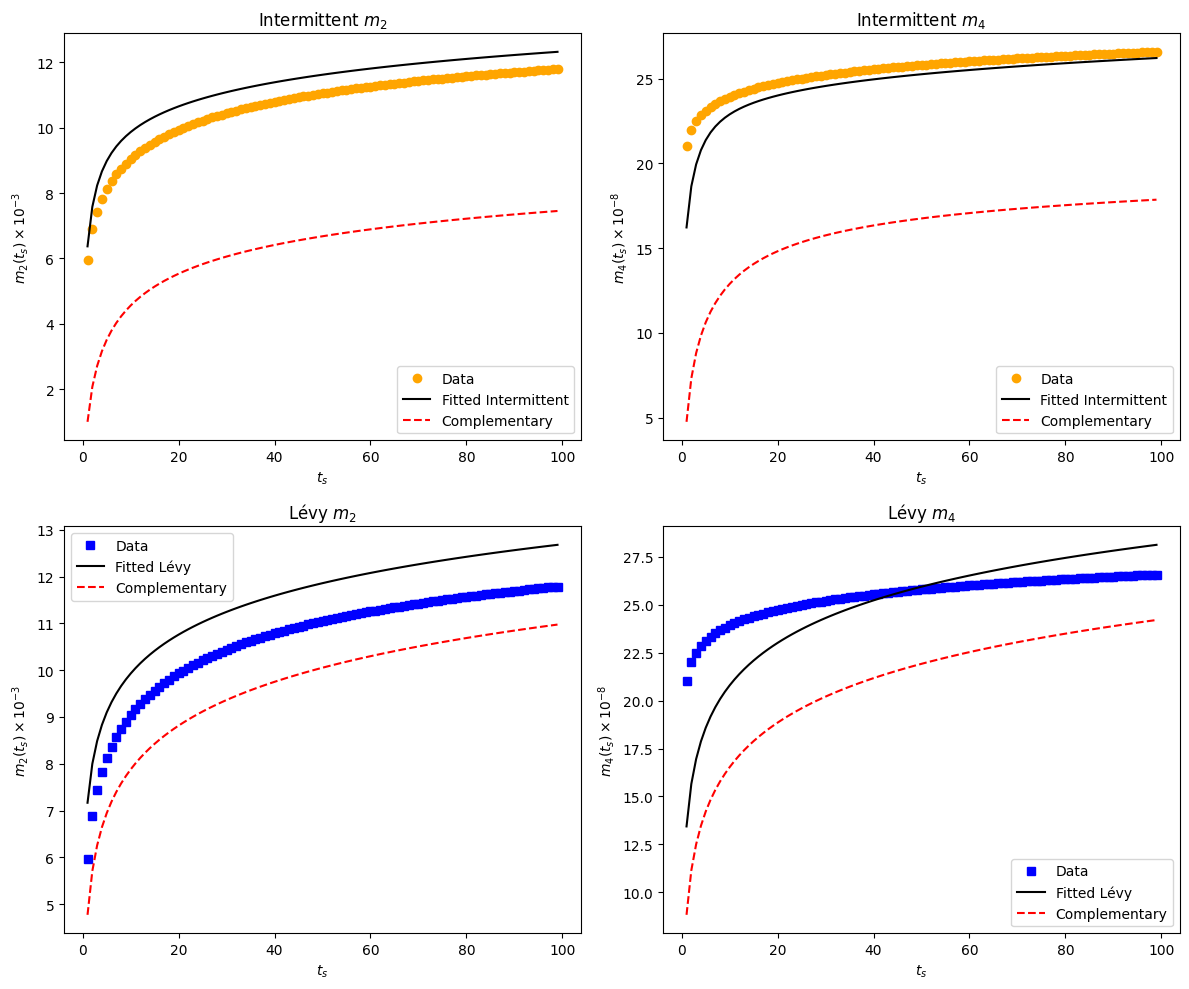

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assume your data (from previous steps) is already available
tau_list = np.arange(1, 100)

avg_int_mom2 = np.mean(np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt'), axis=0)
avg_int_mom4 = np.mean(np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt'), axis=0)
avg_lev_mom2 = np.mean(np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt'), axis=0)
avg_lev_mom4 = np.mean(np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt'), axis=0)

fitted_mom2_IS = mom2_serg_log(tau_list[:len(dx2_log)], *optimized_params_IS)
fitted_mom4_IS = mom4_serg_log(tau_list[:len(dx4_log)], *optimized_params_IS)

fitted_mom2_LW = levy_moments_log(2, optimized_alpha, optimized_v_mean, tau_list[:len(dx2_log)], 0.01)
fitted_mom4_LW = levy_moments_log(4, optimized_alpha, optimized_v_mean, tau_list[:len(dx4_log)], 0.01)

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Intermittent m2 plot
axes[0, 0].plot(tau_list[:len(dx2_log)], dx2_log, 'o', color='orange', label="Data")
axes[0, 0].plot(tau_list[:len(fitted_mom2_IS)], fitted_mom2_IS, '-', color='black', label="Fitted Intermittent")
axes[0, 0].plot(tau_list, avg_int_mom2, '--', color='red', label="Complementary")
axes[0, 0].set_ylabel(r"$m_2(t_s) \times 10^{-3}$")
axes[0, 0].set_xlabel(r"$t_s$")
axes[0, 0].set_title("Intermittent $m_2$")
axes[0, 0].legend()

# Intermittent m4 plot
axes[0, 1].plot(tau_list[:len(dx4_log)], dx4_log, 'o', color='orange', label="Data")
axes[0, 1].plot(tau_list[:len(fitted_mom4_IS)], fitted_mom4_IS, '-', color='black', label="Fitted Intermittent")
axes[0, 1].plot(tau_list, avg_int_mom4, '--', color='red', label="Complementary")
axes[0, 1].set_ylabel(r"$m_4(t_s) \times 10^{-8}$")
axes[0, 1].set_xlabel(r"$t_s$")
axes[0, 1].set_title("Intermittent $m_4$")
axes[0, 1].legend()

# Lévy m2 plot
axes[1, 0].plot(tau_list[:len(dx2_log)], dx2_log, 's', color='blue', label="Data")
axes[1, 0].plot(tau_list[:len(fitted_mom2_LW)], fitted_mom2_LW, '-', color='black', label="Fitted Lévy")
axes[1, 0].plot(tau_list, avg_lev_mom2, '--', color='red', label="Complementary")
axes[1, 0].set_ylabel(r"$m_2(t_s) \times 10^{-3}$")
axes[1, 0].set_xlabel(r"$t_s$")
axes[1, 0].set_title("Lévy $m_2$")
axes[1, 0].legend()

# Lévy m4 plot
axes[1, 1].plot(tau_list[:len(dx4_log)], dx4_log, 's', color='blue', label="Data")
axes[1, 1].plot(tau_list[:len(fitted_mom4_LW)], fitted_mom4_LW, '-', color='black', label="Fitted Lévy")
axes[1, 1].plot(tau_list, avg_lev_mom4, '--', color='red', label="Complementary")
axes[1, 1].set_ylabel(r"$m_4(t_s) \times 10^{-8}$")
axes[1, 1].set_xlabel(r"$t_s$")
axes[1, 1].set_title("Lévy $m_4$")
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Save the plot to a file or display it
plt.savefig("moments_comparison_plot.png", dpi=300)  # Save as PNG
plt.show()


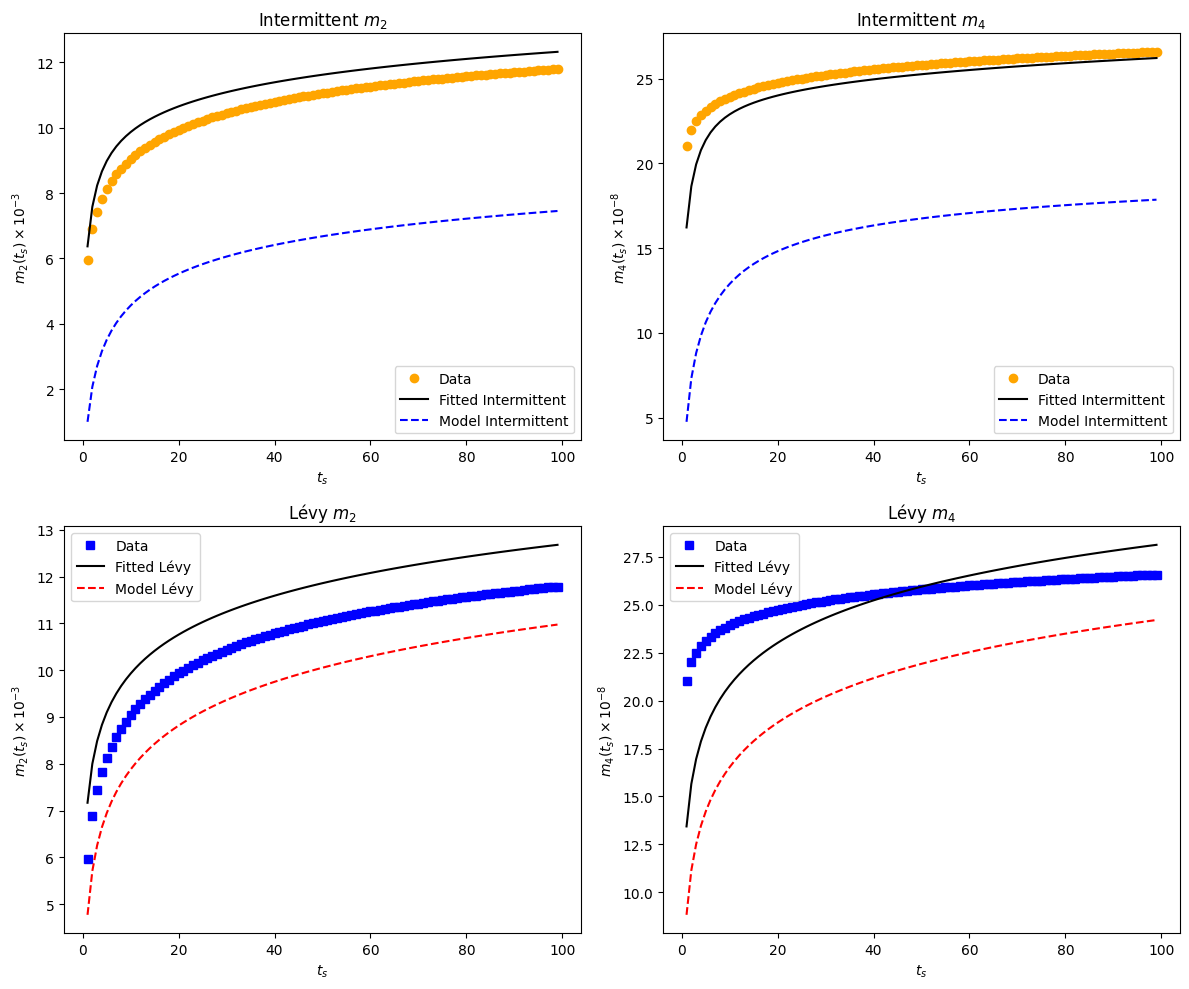

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume your data (from previous steps) is already available


# Model Intermittent Moments
model_int_mom2 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt')
model_int_mom4 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt')

# Model Lévy Moments
model_lev_mom2 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt')
model_lev_mom4 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt')

# Average moments
avg_model_int_mom2 = np.mean(model_int_mom2, axis=0)
avg_model_int_mom4 = np.mean(model_int_mom4, axis=0)
avg_model_lev_mom2 = np.mean(model_lev_mom2, axis=0)
avg_model_lev_mom4 = np.mean(model_lev_mom4, axis=0)

# Fitted moments (computed from your optimization)
fitted_mom2_IS = mom2_serg_log(tau_list[:len(dx2_log)], *optimized_params_IS)
fitted_mom4_IS = mom4_serg_log(tau_list[:len(dx4_log)], *optimized_params_IS)

fitted_mom2_LW = levy_moments_log(2, optimized_alpha, optimized_v_mean, tau_list[:len(dx2_log)], 0.01)
fitted_mom4_LW = levy_moments_log(4, optimized_alpha, optimized_v_mean, tau_list[:len(dx4_log)], 0.01)

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Intermittent m2 plot# Example usage:
folder_path = '/home/shailendra/Documents/PhD_Oslomet/QuantumGanWaldo/WALDO/WalDo'
result = load_eye_tracking_data(folder_path)
axes[0, 0].plot(tau_list[:len(dx2_log)], dx2_log, 'o', color='orange', label="Data")
axes[0, 0].plot(tau_list[:len(fitted_mom2_IS)], fitted_mom2_IS, '-', color='black', label="Fitted Intermittent")
axes[0, 0].plot(tau_list, avg_model_int_mom2, '--', color='blue', label="Model Intermittent")
axes[0, 0].set_ylabel(r"$m_2(t_s) \times 10^{-3}$")
axes[0, 0].set_xlabel(r"$t_s$")
axes[0, 0].set_title("Intermittent $m_2$")
axes[0, 0].legend()

# Intermittent m4 plot
axes[0, 1].plot(tau_list[:len(dx4_log)], dx4_log, 'o', color='orange', label="Data")
axes[0, 1].plot(tau_list[:len(fitted_mom4_IS)], fitted_mom4_IS, '-', color='black', label="Fitted Intermittent")
axes[0, 1].plot(tau_list, avg_model_int_mom4, '--', color='blue', label="Model Intermittent")
axes[0, 1].set_ylabel(r"$m_4(t_s) \times 10^{-8}$")
axes[0, 1].set_xlabel(r"$t_s$")
axes[0, 1].set_title("Intermittent $m_4$")
axes[0, 1].legend()

# Lévy m2 plot
axes[1, 0].plot(tau_list[:len(dx2_log)], dx2_log, 's', color='blue', label="Data")
axes[1, 0].plot(tau_list[:len(fitted_mom2_LW)], fitted_mom2_LW, '-', color='black', label="Fitted Lévy")
axes[1, 0].plot(tau_list, avg_model_lev_mom2, '--', color='red', label="Model Lévy")
axes[1, 0].set_ylabel(r"$m_2(t_s) \times 10^{-3}$")
axes[1, 0].set_xlabel(r"$t_s$")
axes[1, 0].set_title("Lévy $m_2$")
axes[1, 0].legend()

# Lévy m4 plot
axes[1, 1].plot(tau_list[:len(dx4_log)], dx4_log, 's', color='blue', label="Data")
axes[1, 1].plot(tau_list[:len(fitted_mom4_LW)], fitted_mom4_LW, '-', color='black', label="Fitted Lévy")
axes[1, 1].plot(tau_list, avg_model_lev_mom4, '--', color='red', label="Model Lévy")
axes[1, 1].set_ylabel(r"$m_4(t_s) \times 10^{-8}$")
axes[1, 1].set_xlabel(r"$t_s$")
axes[1, 1].set_title("Lévy $m_4$")
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Save the plot to a file or display it
plt.savefig("moments_comparison_plot_updated.png", dpi=300)  # Save as PNG
plt.show()


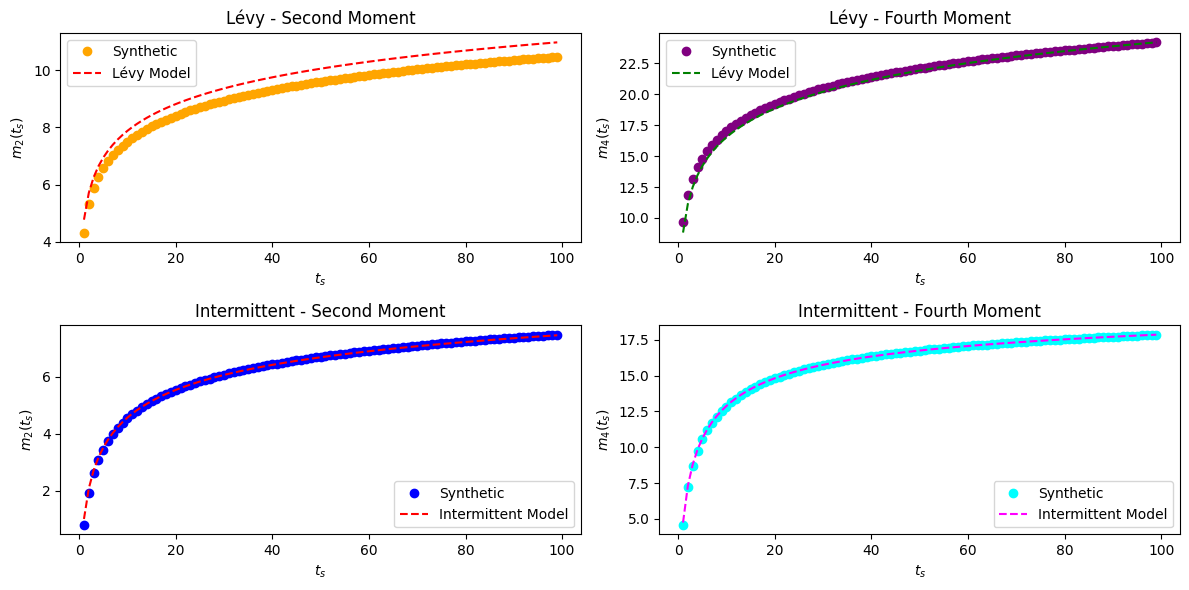

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved data
levy_m2 = np.loadtxt('results/levy/lev_generated_logdx2_list.txt')
levy_m4 = np.loadtxt('results/levy/lev_generated_logdx4_list.txt')
intermittent_m2 = np.loadtxt('results/intermittent/int_generated_logdx2_list.txt')
intermittent_m4 = np.loadtxt('results/intermittent/int_generated_logdx4_list.txt')

levy_fit_m2 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt')
levy_fit_m4 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt')
intermittent_fit_m2 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt')
intermittent_fit_m4 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt')

# Define tau_list (assuming the same tau_list is used for both simulations)
tau_list = np.arange(1, 100)

# Calculate the average over iterations
avg_levy_m2 = np.mean(levy_m2, axis=0)
avg_levy_m4 = np.mean(levy_m4, axis=0)
avg_intermittent_m2 = np.mean(intermittent_m2, axis=0)
avg_intermittent_m4 = np.mean(intermittent_m4, axis=0)

avg_levy_fit_m2 = np.mean(levy_fit_m2, axis=0)
avg_levy_fit_m4 = np.mean(levy_fit_m4, axis=0)
avg_intermittent_fit_m2 = np.mean(intermittent_fit_m2, axis=0)
avg_intermittent_fit_m4 = np.mean(intermittent_fit_m4, axis=0)

# Create the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Plot Lévy moments
axes[0, 0].plot(tau_list, avg_levy_m2, 'o', color='orange', label='Synthetic')
axes[0, 0].plot(tau_list, avg_levy_fit_m2, '--', color='red', label='Lévy Model')
axes[0, 0].set_title("Lévy - Second Moment")
axes[0, 0].set_xlabel('$t_s$')
axes[0, 0].set_ylabel('$m_2(t_s)$')
axes[0, 0].legend()

axes[0, 1].plot(tau_list, avg_levy_m4, 'o', color='purple', label='Synthetic')
axes[0, 1].plot(tau_list, avg_levy_fit_m4, '--', color='green', label='Lévy Model')
axes[0, 1].set_title("Lévy - Fourth Moment")
axes[0, 1].set_xlabel('$t_s$')
axes[0, 1].set_ylabel('$m_4(t_s)$')
axes[0, 1].legend()

# Plot Intermittent moments
axes[1, 0].plot(tau_list, avg_intermittent_m2, 'o', color='blue', label='Synthetic')
axes[1, 0].plot(tau_list, avg_intermittent_fit_m2, '--', color='red', label='Intermittent Model')
axes[1, 0].set_title("Intermittent - Second Moment")
axes[1, 0].set_xlabel('$t_s$')
axes[1, 0].set_ylabel('$m_2(t_s)$')
axes[1, 0].legend()

axes[1, 1].plot(tau_list, avg_intermittent_m4, 'o', color='cyan', label='Synthetic')
axes[1, 1].plot(tau_list, avg_intermittent_fit_m4, '--', color='magenta', label='Intermittent Model')
axes[1, 1].set_title("Intermittent - Fourth Moment")
axes[1, 1].set_xlabel('$t_s$')
axes[1, 1].set_ylabel('$m_4(t_s)$')
axes[1, 1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


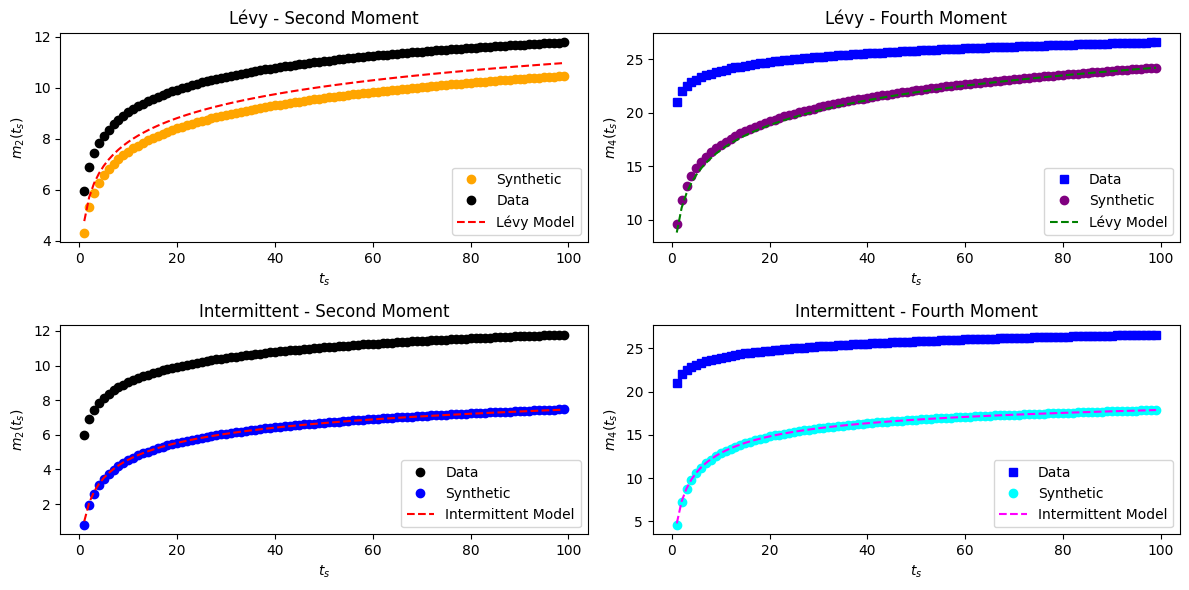

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved data
levy_m2 = np.loadtxt('results/levy/lev_generated_logdx2_list.txt')
levy_m4 = np.loadtxt('results/levy/lev_generated_logdx4_list.txt')
intermittent_m2 = np.loadtxt('results/intermittent/int_generated_logdx2_list.txt')
intermittent_m4 = np.loadtxt('results/intermittent/int_generated_logdx4_list.txt')

levy_fit_m2 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt')
levy_fit_m4 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt')
intermittent_fit_m2 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt')
intermittent_fit_m4 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt')

# Define tau_list (assuming the same tau_list is used for both simulations)
tau_list = np.arange(1, 100)

# Calculate the average over iterations
avg_levy_m2 = np.mean(levy_m2, axis=0)
avg_levy_m4 = np.mean(levy_m4, axis=0)
avg_intermittent_m2 = np.mean(intermittent_m2, axis=0)
avg_intermittent_m4 = np.mean(intermittent_m4, axis=0)

avg_levy_fit_m2 = np.mean(levy_fit_m2, axis=0)
avg_levy_fit_m4 = np.mean(levy_fit_m4, axis=0)
avg_intermittent_fit_m2 = np.mean(intermittent_fit_m2, axis=0)
avg_intermittent_fit_m4 = np.mean(intermittent_fit_m4, axis=0)

# Create the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Plot Lévy moments
axes[0, 0].plot(tau_list, avg_levy_m2, 'o', color='orange', label='Synthetic')
axes[0, 0].plot(tau_list[:len(dx2_log)], dx2_log, 'o', color='black', label="Data")
axes[0, 0].plot(tau_list, avg_levy_fit_m2, '--', color='red', label='Lévy Model')
axes[0, 0].set_title("Lévy - Second Moment")
axes[0, 0].set_xlabel('$t_s$')
axes[0, 0].set_ylabel('$m_2(t_s)$')
axes[0, 0].legend()

axes[0, 1].plot(tau_list[:len(dx4_log)], dx4_log, 's', color='blue', label="Data")
axes[0, 1].plot(tau_list, avg_levy_m4, 'o', color='purple', label='Synthetic')
axes[0, 1].plot(tau_list, avg_levy_fit_m4, '--', color='green', label='Lévy Model')
axes[0, 1].set_title("Lévy - Fourth Moment")
axes[0, 1].set_xlabel('$t_s$')
axes[0, 1].set_ylabel('$m_4(t_s)$')
axes[0, 1].legend()

# Plot Intermittent moments
axes[1, 0].plot(tau_list[:len(dx2_log)], dx2_log, 'o', color='black', label="Data")
axes[1, 0].plot(tau_list, avg_intermittent_m2, 'o', color='blue', label='Synthetic')
axes[1, 0].plot(tau_list, avg_intermittent_fit_m2, '--', color='red', label='Intermittent Model')
axes[1, 0].set_title("Intermittent - Second Moment")
axes[1, 0].set_xlabel('$t_s$')
axes[1, 0].set_ylabel('$m_2(t_s)$')
axes[1, 0].legend()

axes[1, 1].plot(tau_list[:len(dx4_log)], dx4_log, 's', color='blue', label="Data")
axes[1, 1].plot(tau_list, avg_intermittent_m4, 'o', color='cyan', label='Synthetic')
axes[1, 1].plot(tau_list, avg_intermittent_fit_m4, '--', color='magenta', label='Intermittent Model')
axes[1, 1].set_title("Intermittent - Fourth Moment")
axes[1, 1].set_xlabel('$t_s$')
axes[1, 1].set_ylabel('$m_4(t_s)$')
axes[1, 1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


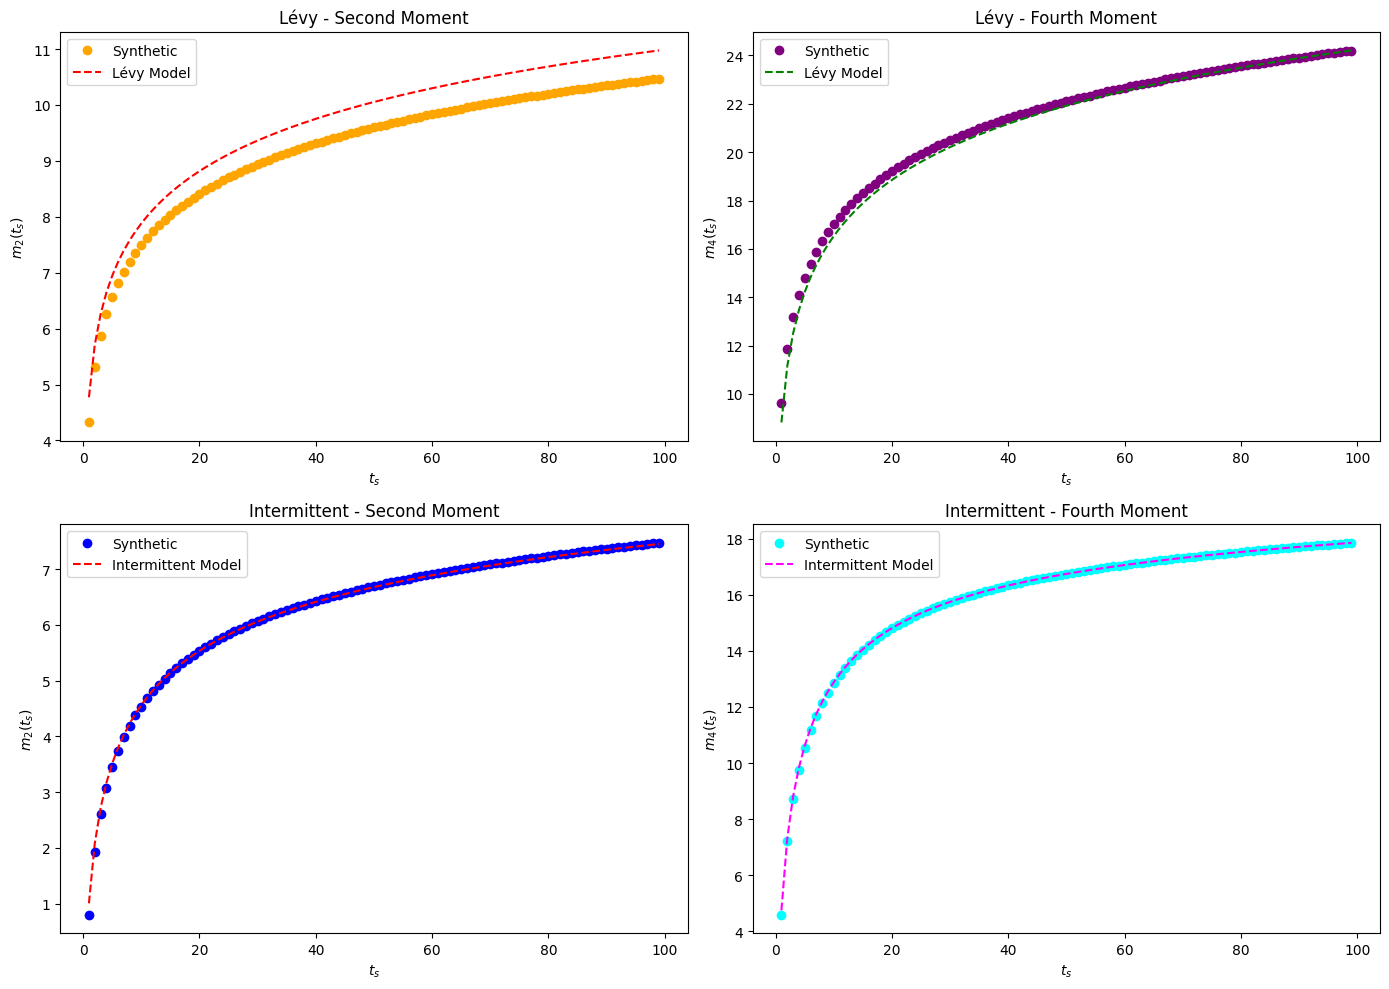

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved data
levy_m2 = np.loadtxt('results/levy/lev_generated_logdx2_list.txt')
levy_m4 = np.loadtxt('results/levy/lev_generated_logdx4_list.txt')
intermittent_m2 = np.loadtxt('results/intermittent/int_generated_logdx2_list.txt')
intermittent_m4 = np.loadtxt('results/intermittent/int_generated_logdx4_list.txt')

levy_fit_m2 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt')
levy_fit_m4 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt')
intermittent_fit_m2 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt')
intermittent_fit_m4 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt')

# Define tau_list (assuming the same tau_list is used for all simulations)
tau_list = np.arange(1, 100)

# Calculate the average over iterations
avg_levy_m2 = np.mean(levy_m2, axis=0)
avg_levy_m4 = np.mean(levy_m4, axis=0)
avg_intermittent_m2 = np.mean(intermittent_m2, axis=0)
avg_intermittent_m4 = np.mean(intermittent_m4, axis=0)

avg_levy_fit_m2 = np.mean(levy_fit_m2, axis=0)
avg_levy_fit_m4 = np.mean(levy_fit_m4, axis=0)
avg_intermittent_fit_m2 = np.mean(intermittent_fit_m2, axis=0)
avg_intermittent_fit_m4 = np.mean(intermittent_fit_m4, axis=0)

# Create the unified plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Lévy moments
axes[0, 0].plot(tau_list, avg_levy_m2, 'o', color='orange', label='Synthetic')
axes[0, 0].plot(tau_list, avg_levy_fit_m2, '--', color='red', label='Lévy Model')
axes[0, 0].set_title("Lévy - Second Moment")
axes[0, 0].set_xlabel('$t_s$')
axes[0, 0].set_ylabel('$m_2(t_s)$')
axes[0, 0].legend()

axes[0, 1].plot(tau_list, avg_levy_m4, 'o', color='purple', label='Synthetic')
axes[0, 1].plot(tau_list, avg_levy_fit_m4, '--', color='green', label='Lévy Model')
axes[0, 1].set_title("Lévy - Fourth Moment")
axes[0, 1].set_xlabel('$t_s$')
axes[0, 1].set_ylabel('$m_4(t_s)$')
axes[0, 1].legend()

# Plot Intermittent moments
axes[1, 0].plot(tau_list, avg_intermittent_m2, 'o', color='blue', label='Synthetic')
axes[1, 0].plot(tau_list, avg_intermittent_fit_m2, '--', color='red', label='Intermittent Model')
axes[1, 0].set_title("Intermittent - Second Moment")
axes[1, 0].set_xlabel('$t_s$')
axes[1, 0].set_ylabel('$m_2(t_s)$')
axes[1, 0].legend()

axes[1, 1].plot(tau_list, avg_intermittent_m4, 'o', color='cyan', label='Synthetic')
axes[1, 1].plot(tau_list, avg_intermittent_fit_m4, '--', color='magenta', label='Intermittent Model')
axes[1, 1].set_title("Intermittent - Fourth Moment")
axes[1, 1].set_xlabel('$t_s$')
axes[1, 1].set_ylabel('$m_4(t_s)$')
axes[1, 1].legend()

# Adjust layout and save the plot
plt.tight_layout()
plt.show()


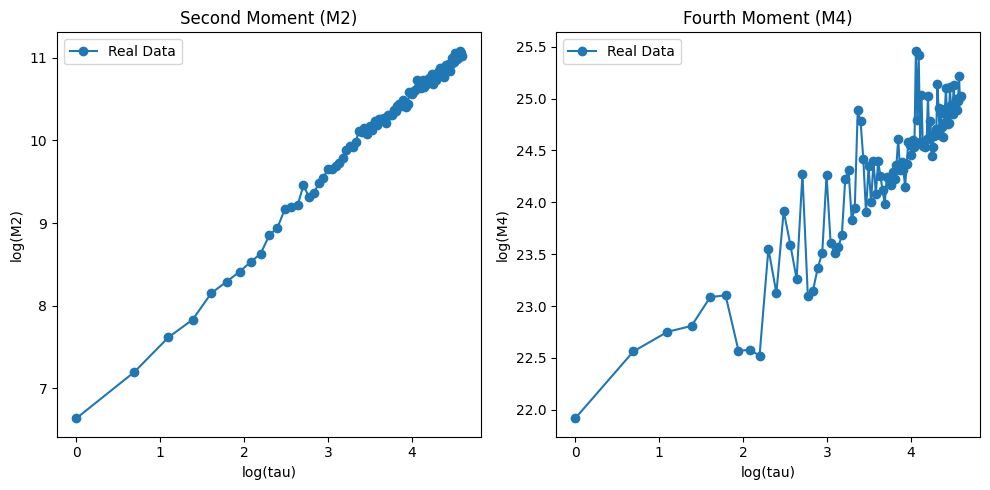

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def calculate_moments(real_data, tau_list):
    """
    Calculate the second and fourth moments for real eye-tracking data.
    
    Parameters:
        real_data (dict): Dictionary containing 'X' and 'Y' coordinate data.
        tau_list (list): List of tau values to compute moments over.
    
    Returns:
        dict: A dictionary containing calculated log M2 and log M4 for the data.
    """
    dx2_log_list = []
    dx4_log_list = []
    
    for X, Y in zip(real_data['X'], real_data['Y']):
        # Clean the data by removing NaNs and zeros
        X, Y = np.array(X), np.array(Y)
        valid_indices = np.isfinite(X) & np.isfinite(Y) & (X != 0) & (Y != 0)
        X, Y = X[valid_indices], Y[valid_indices]

        if len(X) < 2 or len(Y) < 2:
            # Skip this data if insufficient valid points
            continue

        # Calculate second and fourth moments
        dx2 = []
        dx4 = []
        for tau in tau_list:
            dx = np.diff(X[::tau])  # Calculate X displacements
            dy = np.diff(Y[::tau])  # Calculate Y displacements
            displacements = dx**2 + dy**2

            dx2.append(np.mean(displacements))
            dx4.append(np.mean(displacements**2))

        # Take the logarithm of moments, avoiding issues with zero values
        dx2_log_list.append(np.log(np.clip(dx2, a_min=1e-10, a_max=None)))
        dx4_log_list.append(np.log(np.clip(dx4, a_min=1e-10, a_max=None)))

    return {
        'log_M2': np.array(dx2_log_list),
        'log_M4': np.array(dx4_log_list)
    }

def plot_moments(tau_list, log_M2, log_M4, label='Real Data'):
    """
    Plot the calculated second and fourth moments.
    
    Parameters:
        tau_list (list): List of tau values used.
        log_M2 (array): Logarithm of the second moments.
        log_M4 (array): Logarithm of the fourth moments.
        label (str): Label for the data being plotted.
    """
    avg_log_M2 = np.mean(log_M2, axis=0)
    avg_log_M4 = np.mean(log_M4, axis=0)

    plt.figure(figsize=(10, 5))

    # Plot log M2
    plt.subplot(1, 2, 1)
    plt.plot(np.log(tau_list), avg_log_M2, 'o-', label=label)
    plt.xlabel('log(tau)')
    plt.ylabel('log(M2)')
    plt.title('Second Moment (M2)')
    plt.legend()

    # Plot log M4
    plt.subplot(1, 2, 2)
    plt.plot(np.log(tau_list), avg_log_M4, 'o-', label=label)
    plt.xlabel('log(tau)')
    plt.ylabel('log(M4)')
    plt.title('Fourth Moment (M4)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Load real eye-tracking data
folder_path = '/home/shailendra/Documents/PhD_Oslomet/QuantumGanWaldo/WALDO/WalDo'
real_data = load_eye_tracking_data(folder_path)

# Define tau values
tau_list = np.arange(1, 100)

# Calculate moments for the real data
moments = calculate_moments(real_data, tau_list)

# Plot the calculated moments
plot_moments(tau_list, moments['log_M2'], moments['log_M4'])


# Lastest code  

In [ ]:
import numpy as np
import os

def load_eye_tracking_data(folder_path, file_extension='.txt', remove_first_n_points=250):
    """
    Load and preprocess eye-tracking data from multiple .txt files in a folder.

    Parameters:
        folder_path (str): Path to the folder containing the .txt files.
        file_extension (str): Extension of the files to load (default: '.txt').
        remove_first_n_points (int): Number of initial points to remove from each file.

    Returns:
        dict: A dictionary containing lists of cleaned data for time (T), x-coordinates (X),
              y-coordinates (Y), and saccades (saccade).
    """
    # Get list of files matching the extension
    files = [file for file in os.listdir(folder_path) if file.endswith(file_extension)]
    if not files:
        raise FileNotFoundError(f"No files found with extension '{file_extension}' in '{folder_path}'.")

    # Initialize lists to store data
    T, X, Y, saccade = [], [], [], []

    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            # Load data
            data = np.loadtxt(file_path)
            if data.shape[0] > data.shape[1]:
                data = data.T  # Transpose if rows > columns

            # Extract columns
            T_i = data[0]
            X_i = data[1]
            Y_i = data[2]
            saccade_i = data[3]

            # Remove initial points
            T_i = T_i[remove_first_n_points:]
            X_i = X_i[remove_first_n_points:]
            Y_i = Y_i[remove_first_n_points:]
            saccade_i = saccade_i[remove_first_n_points:]

            # Append cleaned data
            T.append(T_i)
            X.append(X_i)
            Y.append(Y_i)
            saccade.append(saccade_i)

        except Exception as e:
            print(f"Error loading {file}: {e}")

    return {
        "T": T,
        "X": X,
        "Y": Y,
        "saccade": saccade
    }

# Example usage:
#folder_path = '/path/to/your/eye_tracking_data'  # Replace with your folder path
#real_data = load_eye_tracking_data(folder_path)

print(f"Number of files processed: {len(real_data['T'])}")


Number of files processed: 1


In [24]:
def calculate_real_moments(real_data, tau_list):
    """
    Calculate the second and fourth moments for real eye-tracking data.

    Parameters:
        real_data (dict): Dictionary containing 'X' and 'Y' coordinate data.
        tau_list (list): List of tau values to compute moments over.

    Returns:
        dict: A dictionary containing calculated log M2 and log M4 for the data.
    """
    dx2_log_list = []
    dx4_log_list = []

    for X, Y in zip(real_data['X'], real_data['Y']):
        # Clean the data by removing NaNs and zeros
        X, Y = np.array(X), np.array(Y)
        valid_indices = np.isfinite(X) & np.isfinite(Y) & (X != 0) & (Y != 0)
        X, Y = X[valid_indices], Y[valid_indices]

        if len(X) < max(tau_list):
            # Skip this data if insufficient valid points
            continue

        # Calculate second and fourth moments
        dx2 = []
        dx4 = []
        for tau in tau_list:
            dt = int(tau)
            dx = X[dt:] - X[:-dt]
            dy = Y[dt:] - Y[:-dt]
            displacement = dx**2 + dy**2

            dx2.append(np.mean(displacement))
            dx4.append(np.mean(displacement**2))

        # Take the logarithm of moments, avoiding issues with zero values
        dx2_log_list.append(np.log(np.clip(dx2, a_min=1e-10, a_max=None)))
        dx4_log_list.append(np.log(np.clip(dx4, a_min=1e-10, a_max=None)))

    return {
        'log_M2': np.array(dx2_log_list),
        'log_M4': np.array(dx4_log_list)
    }

# Define tau values
tau_list = np.arange(1, 100)

# Calculate moments for the real data
real_moments = calculate_real_moments(real_data, tau_list)

print(f"Calculated moments for {len(real_moments['log_M2'])} trajectories.")


Calculated moments for 1 trajectories.


In [25]:
# Load synthetic intermittent process moments
int_moments_m2 = np.loadtxt('results/intermittent/int_generated_logdx2_list.txt')
int_moments_m4 = np.loadtxt('results/intermittent/int_generated_logdx4_list.txt')

# Load synthetic Lévy process moments
levy_moments_m2 = np.loadtxt('results/levy/lev_generated_logdx2_list.txt')
levy_moments_m4 = np.loadtxt('results/levy/lev_generated_logdx4_list.txt')


In [26]:
# Average synthetic intermittent moments
avg_int_moments_m2 = np.mean(int_moments_m2, axis=0)
avg_int_moments_m4 = np.mean(int_moments_m4, axis=0)

# Average synthetic Lévy moments
avg_levy_moments_m2 = np.mean(levy_moments_m2, axis=0)
avg_levy_moments_m4 = np.mean(levy_moments_m4, axis=0)


In [ ]:
from scipy.optimize import differential_evolution
from intermittent_levy.moments import mom2_serg_log, mom4_serg_log, levy_moments_log
from intermittent_levy.optimization import to_optimize_mom4_and_2_serg_log, to_optimize_levy
from intermittent_levy.utils import adjusted_r_square

# For simplicity, we'll use the average moments of the real data
avg_real_m2 = np.mean(real_moments['log_M2'], axis=0)
avg_real_m4 = np.mean(real_moments['log_M4'], axis=0)

# Ensure that the lengths match
min_length = min(len(avg_real_m2), len(avg_int_moments_m2), len(avg_levy_moments_m2))
tau_list = tau_list[:min_length]
avg_real_m2 = avg_real_m2[:min_length]
avg_real_m4 = avg_real_m4[:min_length]

# Fit Intermittent Model
def fit_intermittent_model(tau_list, dx2_log, dx4_log):
    # Initial parameter estimates
    v0_est = 15
    D_est = 2
    lambda_B_est = 0.2
    lambda_D_est = 0.2

    # Define bounds
    bounds_IS = [
        (v0_est / 10, v0_est * 10),
        (D_est / 10, D_est * 10),
        (lambda_B_est / 10, lambda_B_est * 10),
        (lambda_D_est / 10, lambda_D_est * 10)
    ]

    args_IS = (tau_list, dx2_log, dx4_log)

    # Optimize
    result_IS = differential_evolution(
        to_optimize_mom4_and_2_serg_log,
        bounds=bounds_IS,
        args=args_IS
    )

    optimized_params_IS = result_IS.x

    # Compute fitted moments
    fitted_mom2_IS = mom2_serg_log(tau_list, *optimized_params_IS)
    fitted_mom4_IS = mom4_serg_log(tau_list, *optimized_params_IS)

    return optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS

# Fit Lévy Model
def fit_levy_model(tau_list, dx2_log, dx4_log):
    # Initial parameter estimates
    alpha_est = 2.7
    v_mean_est = 15
    tmin_est = 0.01

    # Define bounds
    bounds_LW = [
        (1.3, 2.99),  # Alpha between 1.1 and 2.99
        (v_mean_est / 10, v_mean_est * 10)
    ]

    args_LW = (tau_list, dx2_log, dx4_log, tmin_est)

    # Optimize
    result_LW = differential_evolution(
        to_optimize_levy,
        bounds=bounds_LW,
        args=args_LW
    )

    optimized_alpha, optimized_v_mean = result_LW.x

    # Compute fitted moments
    fitted_mom2_LW = levy_moments_log(2, optimized_alpha, optimized_v_mean, tau_list, tmin_est)
    fitted_mom4_LW = levy_moments_log(4, optimized_alpha, optimized_v_mean, tau_list, tmin_est)

    return (optimized_alpha, optimized_v_mean), fitted_mom2_LW, fitted_mom4_LW

# Fit models to the real data
optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS = fit_intermittent_model(tau_list, avg_real_m2, avg_real_m4)
optimized_params_LW, fitted_mom2_LW, fitted_mom4_LW = fit_levy_model(tau_list, avg_real_m2, avg_real_m4)


In [28]:
# Adjusted R-squared for Intermittent Model
r2_mom2_IS = adjusted_r_square(avg_real_m2, fitted_mom2_IS, degrees_freedom=4)
r2_mom4_IS = adjusted_r_square(avg_real_m4, fitted_mom4_IS, degrees_freedom=4)
R2_IS = (r2_mom2_IS + r2_mom4_IS) / 2

# Adjusted R-squared for Lévy Model
r2_mom2_LW = adjusted_r_square(avg_real_m2, fitted_mom2_LW, degrees_freedom=2)
r2_mom4_LW = adjusted_r_square(avg_real_m4, fitted_mom4_LW, degrees_freedom=2)
R2_LW = (r2_mom2_LW + r2_mom4_LW) / 2

print("Adjusted R^2 for Intermittent Search Model:", R2_IS)
print("Adjusted R^2 for Lévy Walk Model:", R2_LW)

if R2_IS > R2_LW:
    print("The Intermittent Search Model fits the eye-tracking data better.")
else:
    print("The Lévy Walk Model fits the eye-tracking data better.")


Adjusted R^2 for Intermittent Search Model: -0.57138158105845666403
Adjusted R^2 for Lévy Walk Model: -5.420724343478965
The Intermittent Search Model fits the eye-tracking data better.


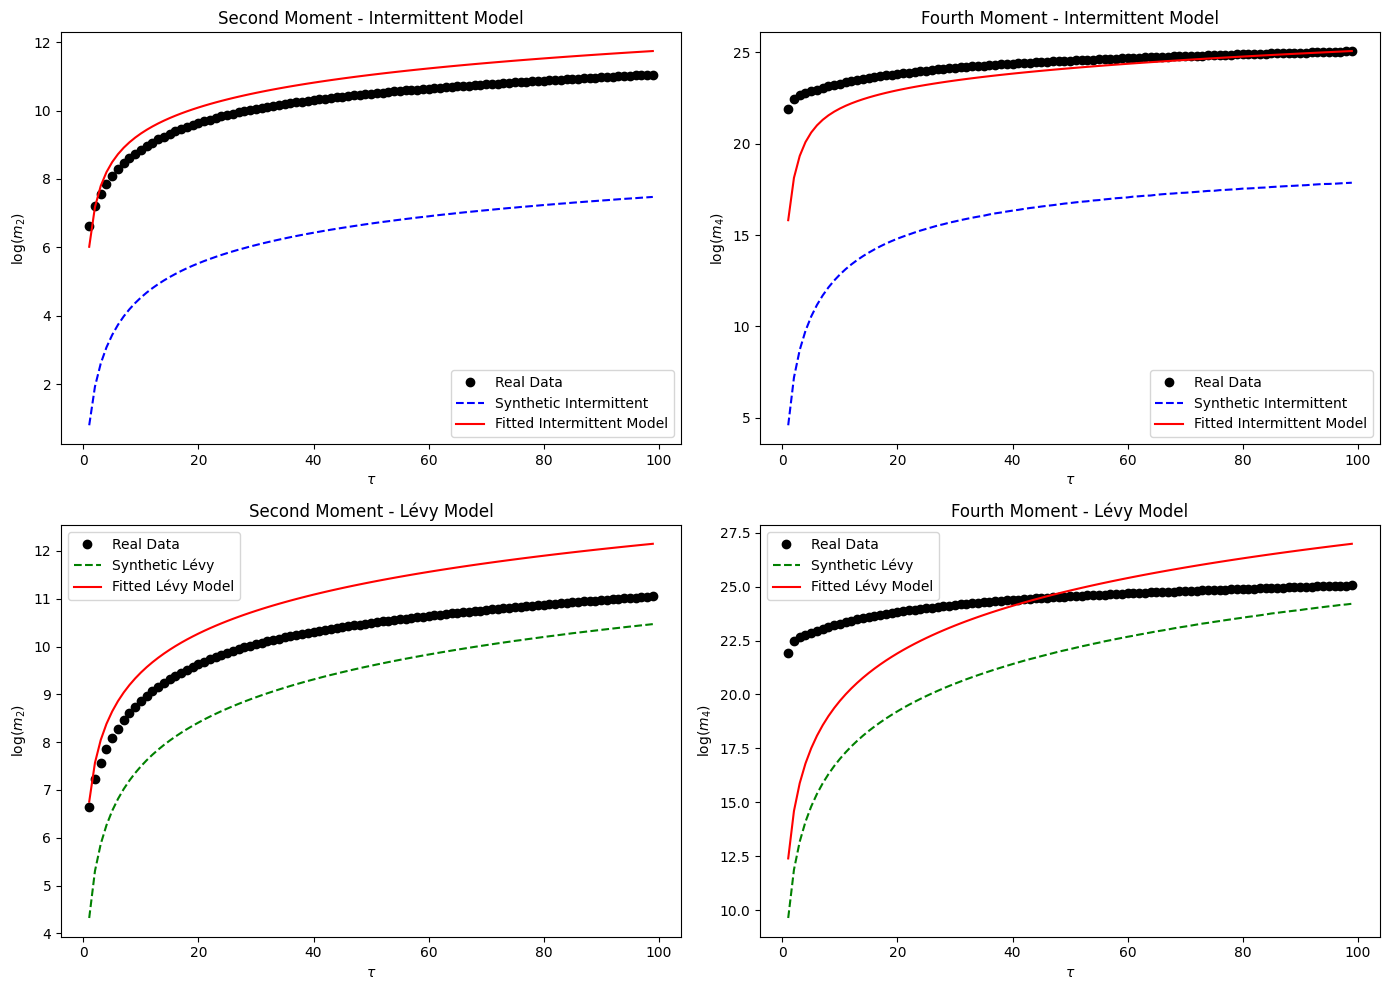

In [29]:
import matplotlib.pyplot as plt

# Plotting the moments
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Second Moment - Intermittent Model
axes[0, 0].plot(tau_list, avg_real_m2, 'o', color='black', label='Real Data')
axes[0, 0].plot(tau_list, avg_int_moments_m2, '--', color='blue', label='Synthetic Intermittent')
axes[0, 0].plot(tau_list, fitted_mom2_IS, '-', color='red', label='Fitted Intermittent Model')
axes[0, 0].set_title('Second Moment - Intermittent Model')
axes[0, 0].set_xlabel('$\\tau$')
axes[0, 0].set_ylabel('$\\log(m_2)$')
axes[0, 0].legend()

# Fourth Moment - Intermittent Model
axes[0, 1].plot(tau_list, avg_real_m4, 'o', color='black', label='Real Data')
axes[0, 1].plot(tau_list, avg_int_moments_m4, '--', color='blue', label='Synthetic Intermittent')
axes[0, 1].plot(tau_list, fitted_mom4_IS, '-', color='red', label='Fitted Intermittent Model')
axes[0, 1].set_title('Fourth Moment - Intermittent Model')
axes[0, 1].set_xlabel('$\\tau$')
axes[0, 1].set_ylabel('$\\log(m_4)$')
axes[0, 1].legend()

# Second Moment - Lévy Model
axes[1, 0].plot(tau_list, avg_real_m2, 'o', color='black', label='Real Data')
axes[1, 0].plot(tau_list, avg_levy_moments_m2, '--', color='green', label='Synthetic Lévy')
axes[1, 0].plot(tau_list, fitted_mom2_LW, '-', color='red', label='Fitted Lévy Model')
axes[1, 0].set_title('Second Moment - Lévy Model')
axes[1, 0].set_xlabel('$\\tau$')
axes[1, 0].set_ylabel('$\\log(m_2)$')
axes[1, 0].legend()

# Fourth Moment - Lévy Model
axes[1, 1].plot(tau_list, avg_real_m4, 'o', color='black', label='Real Data')
axes[1, 1].plot(tau_list, avg_levy_moments_m4, '--', color='green', label='Synthetic Lévy')
axes[1, 1].plot(tau_list, fitted_mom4_LW, '-', color='red', label='Fitted Lévy Model')
axes[1, 1].set_title('Fourth Moment - Lévy Model')
axes[1, 1].set_xlabel('$\\tau$')
axes[1, 1].set_ylabel('$\\log(m_4)$')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


Number of files processed: 1
Calculated moments for 1 trajectories.


/home/shailendra/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Adjusted R^2 for Intermittent Search Model: 0.78246716755363182757
Adjusted R^2 for Lévy Walk Model: -5.436552879789742
The data is classified as 'Intermittent' based on the higher adjusted R-squared value.


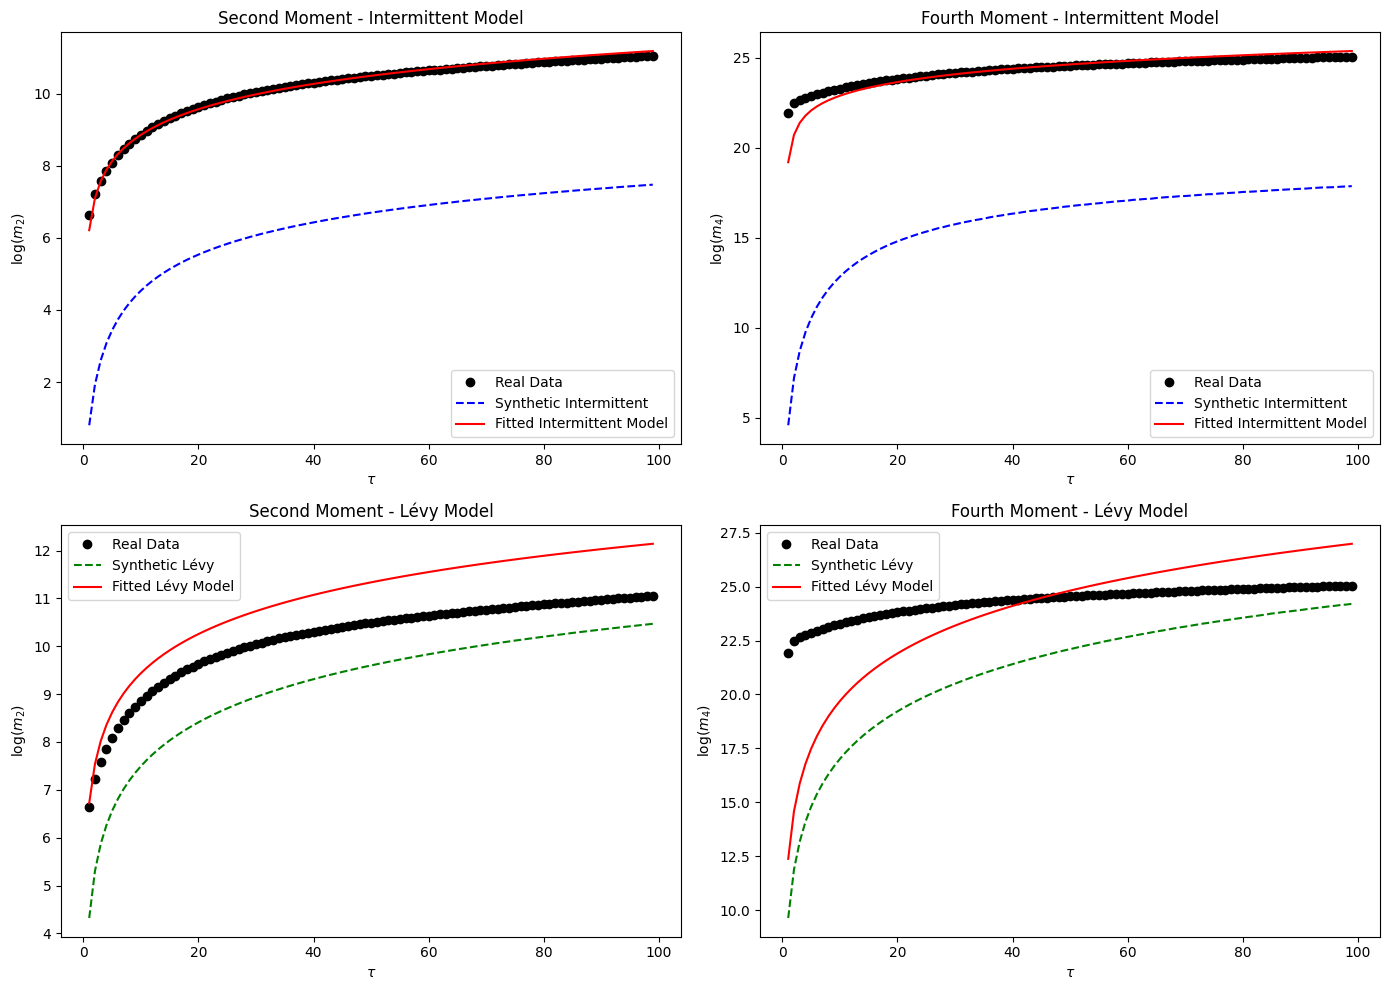

The data is classified as 'Intermittent' based on the higher adjusted R-squared value.


In [31]:
# Import necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from intermittent_levy.moments import (
    mom2_serg_log,
    mom4_serg_log,
    levy_moments_log
)
from intermittent_levy.optimization import (
    to_optimize_mom4_and_2_serg_log,
    to_optimize_levy
)
from intermittent_levy.utils import adjusted_r_square

# Step 1: Load and preprocess real eye-tracking data
def load_eye_tracking_data(folder_path, file_extension='.txt', remove_first_n_points=250):
    """
    Load and preprocess eye-tracking data from multiple files in a folder.

    Parameters:
        folder_path (str): Path to the folder containing the data files.
        file_extension (str): Extension of the files to load.
        remove_first_n_points (int): Number of initial points to remove from each file.

    Returns:
        dict: A dictionary containing lists of cleaned data for time (T), x-coordinates (X),
              y-coordinates (Y), and saccades (saccade).
    """
    # Get list of files matching the extension
    files = [file for file in os.listdir(folder_path) if file.endswith(file_extension)]
    if not files:
        raise FileNotFoundError(f"No files found with extension '{file_extension}' in '{folder_path}'.")

    # Initialize lists to store data
    T, X, Y, saccade = [], [], [], []

    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            # Load data
            data = np.loadtxt(file_path)
            if data.shape[0] > data.shape[1]:
                data = data.T  # Transpose if rows > columns

            # Extract columns
            T_i = data[0]
            X_i = data[1]
            Y_i = data[2]
            saccade_i = data[3]

            # Remove initial points
            T_i = T_i[remove_first_n_points:]
            X_i = X_i[remove_first_n_points:]
            Y_i = Y_i[remove_first_n_points:]
            saccade_i = saccade_i[remove_first_n_points:]

            # Append cleaned data
            T.append(T_i)
            X.append(X_i)
            Y.append(Y_i)
            saccade.append(saccade_i)

        except Exception as e:
            print(f"Error loading {file}: {e}")

    return {
        "T": T,
        "X": X,
        "Y": Y,
        "saccade": saccade
    }

# Load real data
#folder_path = '/path/to/your/eye_tracking_data'  # Replace with your folder path
#real_data = load_eye_tracking_data(folder_path)

print(f"Number of files processed: {len(real_data['T'])}")

# Step 2: Calculate the second and fourth moments for the real data
def calculate_real_moments(real_data, tau_list):
    """
    Calculate the second and fourth moments for real eye-tracking data.

    Parameters:
        real_data (dict): Dictionary containing 'X' and 'Y' coordinate data.
        tau_list (list): List of tau values to compute moments over.

    Returns:
        dict: A dictionary containing calculated log M2 and log M4 for the data.
    """
    dx2_log_list = []
    dx4_log_list = []

    for X, Y in zip(real_data['X'], real_data['Y']):
        # Clean the data by removing NaNs and zeros
        X, Y = np.array(X), np.array(Y)
        valid_indices = np.isfinite(X) & np.isfinite(Y)
        X, Y = X[valid_indices], Y[valid_indices]

        if len(X) < max(tau_list) + 1:
            # Skip this data if insufficient valid points
            continue

        # Calculate second and fourth moments
        dx2 = []
        dx4 = []
        for tau in tau_list:
            dt = int(tau)
            dx = X[dt:] - X[:-dt]
            dy = Y[dt:] - Y[:-dt]
            displacement = dx**2 + dy**2

            # Exclude zero or negative displacements
            displacement = displacement[displacement > 0]

            if len(displacement) == 0:
                dx2.append(np.nan)
                dx4.append(np.nan)
                continue

            dx2.append(np.mean(displacement))
            dx4.append(np.mean(displacement**2))

        # Take the logarithm of moments, avoiding issues with zero or negative values
        dx2 = np.array(dx2)
        dx4 = np.array(dx4)
        dx2_log = np.log(dx2[~np.isnan(dx2)])
        dx4_log = np.log(dx4[~np.isnan(dx4)])

        dx2_log_list.append(dx2_log)
        dx4_log_list.append(dx4_log)

    return {
        'log_M2': np.array(dx2_log_list),
        'log_M4': np.array(dx4_log_list)
    }

# Define tau values
tau_list = np.arange(1, 100)

# Calculate moments for the real data
real_moments = calculate_real_moments(real_data, tau_list)

print(f"Calculated moments for {len(real_moments['log_M2'])} trajectories.")

# Step 3: Load synthetic data for both Lévy and Intermittent models
# Ensure that the synthetic data files are in the specified directories
# Load synthetic intermittent process moments
int_moments_m2 = np.loadtxt('results/intermittent/int_generated_logdx2_list.txt')
int_moments_m4 = np.loadtxt('results/intermittent/int_generated_logdx4_list.txt')

# Load synthetic Lévy process moments
levy_moments_m2 = np.loadtxt('results/levy/lev_generated_logdx2_list.txt')
levy_moments_m4 = np.loadtxt('results/levy/lev_generated_logdx4_list.txt')

# Step 4: Calculate the average moments for the synthetic data
# Average synthetic intermittent moments
avg_int_moments_m2 = np.mean(int_moments_m2, axis=0)
avg_int_moments_m4 = np.mean(int_moments_m4, axis=0)

# Average synthetic Lévy moments
avg_levy_moments_m2 = np.mean(levy_moments_m2, axis=0)
avg_levy_moments_m4 = np.mean(levy_moments_m4, axis=0)

# Step 5: Fit both models to the real data
# For simplicity, we'll use the average moments of the real data
avg_real_m2 = np.nanmean(real_moments['log_M2'], axis=0)
avg_real_m4 = np.nanmean(real_moments['log_M4'], axis=0)

# Ensure that the lengths match
min_length = min(len(avg_real_m2), len(avg_int_moments_m2), len(avg_levy_moments_m2))
tau_list = tau_list[:min_length]
avg_real_m2 = avg_real_m2[:min_length]
avg_real_m4 = avg_real_m4[:min_length]
avg_int_moments_m2 = avg_int_moments_m2[:min_length]
avg_int_moments_m4 = avg_int_moments_m4[:min_length]
avg_levy_moments_m2 = avg_levy_moments_m2[:min_length]
avg_levy_moments_m4 = avg_levy_moments_m4[:min_length]

# Fit Intermittent Model
def fit_intermittent_model(tau_list, dx2_log, dx4_log):
    # Initial parameter estimates
    v0_est = 10
    D_est = 1
    lambda_B_est = 0.1
    lambda_D_est = 0.05

    # Define bounds (ensure positive parameters)
    bounds_IS = [
        (v0_est / 100, v0_est * 100),         # v0
        (D_est / 100, D_est * 100),           # D
        (lambda_B_est / 100, lambda_B_est * 100),  # lambda_B
        (lambda_D_est / 100, lambda_D_est * 100)   # lambda_D
    ]

    args_IS = (tau_list, dx2_log, dx4_log)

    # Optimize
    result_IS = differential_evolution(
        to_optimize_mom4_and_2_serg_log,
        bounds=bounds_IS,
        args=args_IS,
        maxiter=1000,
        polish=True
    )

    optimized_params_IS = result_IS.x

    # Compute fitted moments
    fitted_mom2_IS = mom2_serg_log(tau_list, *optimized_params_IS)
    fitted_mom4_IS = mom4_serg_log(tau_list, *optimized_params_IS)

    return optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS

# Fit Lévy Model
def fit_levy_model(tau_list, dx2_log, dx4_log):
    # Initial parameter estimates
    alpha_est = 2.0
    v_mean_est = 10
    tmin_est = 0.01

    # Define bounds
    bounds_LW = [
        (1.1, 3.0),                          # alpha
        (v_mean_est / 100, v_mean_est * 100)  # v_mean
    ]

    args_LW = (tau_list, dx2_log, dx4_log, tmin_est)

    # Optimize
    result_LW = differential_evolution(
        to_optimize_levy,
        bounds=bounds_LW,
        args=args_LW,
        maxiter=1000,
        polish=True
    )

    optimized_alpha, optimized_v_mean = result_LW.x

    # Compute fitted moments
    fitted_mom2_LW = levy_moments_log(2, optimized_alpha, optimized_v_mean, tau_list, tmin_est)
    fitted_mom4_LW = levy_moments_log(4, optimized_alpha, optimized_v_mean, tau_list, tmin_est)

    return (optimized_alpha, optimized_v_mean), fitted_mom2_LW, fitted_mom4_LW

# Fit models to the real data
optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS = fit_intermittent_model(tau_list, avg_real_m2, avg_real_m4)
optimized_params_LW, fitted_mom2_LW, fitted_mom4_LW = fit_levy_model(tau_list, avg_real_m2, avg_real_m4)

# Step 6: Calculate the adjusted R-squared values for both models
# Adjusted R-squared for Intermittent Model
r2_mom2_IS = adjusted_r_square(avg_real_m2, fitted_mom2_IS, degrees_freedom=4)
r2_mom4_IS = adjusted_r_square(avg_real_m4, fitted_mom4_IS, degrees_freedom=4)
R2_IS = (r2_mom2_IS + r2_mom4_IS) / 2

# Adjusted R-squared for Lévy Model
r2_mom2_LW = adjusted_r_square(avg_real_m2, fitted_mom2_LW, degrees_freedom=2)
r2_mom4_LW = adjusted_r_square(avg_real_m4, fitted_mom4_LW, degrees_freedom=2)
R2_LW = (r2_mom2_LW + r2_mom4_LW) / 2

print("Adjusted R^2 for Intermittent Search Model:", R2_IS)
print("Adjusted R^2 for Lévy Walk Model:", R2_LW)

if R2_IS > R2_LW:
    classification = 'Intermittent'
else:
    classification = 'Lévy'

print(f"The data is classified as '{classification}' based on the higher adjusted R-squared value.")

# Step 7: Generate plots to compare the moments
# Plotting the moments
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Second Moment - Intermittent Model
axes[0, 0].plot(tau_list, avg_real_m2, 'o', color='black', label='Real Data')
axes[0, 0].plot(tau_list, avg_int_moments_m2, '--', color='blue', label='Synthetic Intermittent')
axes[0, 0].plot(tau_list, fitted_mom2_IS, '-', color='red', label='Fitted Intermittent Model')
axes[0, 0].set_title('Second Moment - Intermittent Model')
axes[0, 0].set_xlabel('$\\tau$')
axes[0, 0].set_ylabel('$\\log(m_2)$')
axes[0, 0].legend()

# Fourth Moment - Intermittent Model
axes[0, 1].plot(tau_list, avg_real_m4, 'o', color='black', label='Real Data')
axes[0, 1].plot(tau_list, avg_int_moments_m4, '--', color='blue', label='Synthetic Intermittent')
axes[0, 1].plot(tau_list, fitted_mom4_IS, '-', color='red', label='Fitted Intermittent Model')
axes[0, 1].set_title('Fourth Moment - Intermittent Model')
axes[0, 1].set_xlabel('$\\tau$')
axes[0, 1].set_ylabel('$\\log(m_4)$')
axes[0, 1].legend()

# Second Moment - Lévy Model
axes[1, 0].plot(tau_list, avg_real_m2, 'o', color='black', label='Real Data')
axes[1, 0].plot(tau_list, avg_levy_moments_m2, '--', color='green', label='Synthetic Lévy')
axes[1, 0].plot(tau_list, fitted_mom2_LW, '-', color='red', label='Fitted Lévy Model')
axes[1, 0].set_title('Second Moment - Lévy Model')
axes[1, 0].set_xlabel('$\\tau$')
axes[1, 0].set_ylabel('$\\log(m_2)$')
axes[1, 0].legend()

# Fourth Moment - Lévy Model
axes[1, 1].plot(tau_list, avg_real_m4, 'o', color='black', label='Real Data')
axes[1, 1].plot(tau_list, avg_levy_moments_m4, '--', color='green', label='Synthetic Lévy')
axes[1, 1].plot(tau_list, fitted_mom4_LW, '-', color='red', label='Fitted Lévy Model')
axes[1, 1].set_title('Fourth Moment - Lévy Model')
axes[1, 1].set_xlabel('$\\tau$')
axes[1, 1].set_ylabel('$\\log(m_4)$')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Step 8: Classification based on the goodness of fit
print(f"The data is classified as '{classification}' based on the higher adjusted R-squared value.")

# Optional: Save the plot
# plt.savefig("moments_comparison_plot.png", dpi=300)


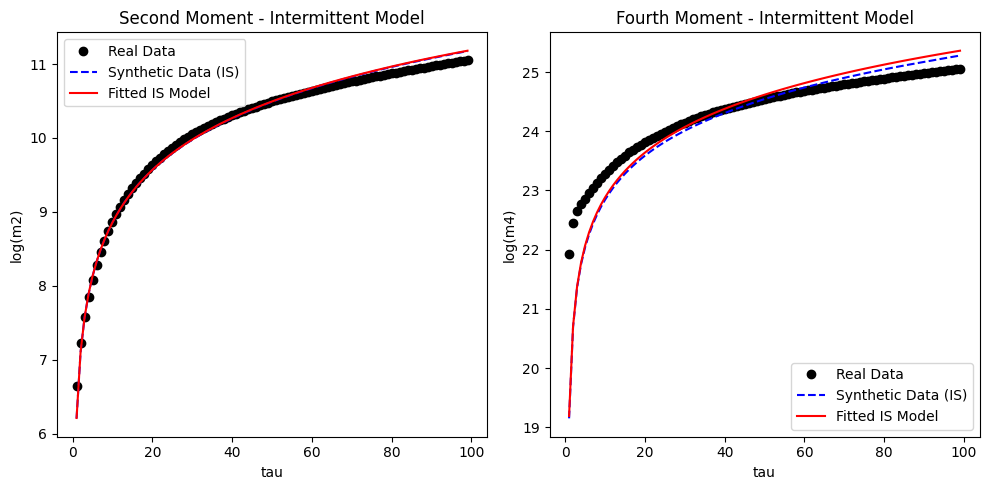

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from intermittent_levy.processes import intermittent3
from intermittent_levy.moments import mom2_serg_log, mom4_serg_log
from intermittent_levy.optimization import to_optimize_mom4_and_2_serg_log
from intermittent_levy.utils import adjusted_r_square
from scipy import optimize

# Use the optimized parameters from fitting the intermittent model to your real data
# Replace these with your actual optimized parameters
#optimized_params_IS = [v0_opt, D_opt, lambda_B_opt, lambda_D_opt]

# Generate synthetic data using the optimized parameters
N = 300000  # Adjust as needed
tau = 1  # Time step

xsynth, ysynth = intermittent3(N, tau, *optimized_params_IS)

# Compute moments
tau_list = np.arange(1, 100)
dx2 = []
dx4 = []
for tau in tau_list:
    dt = int(tau)
    if len(xsynth) < dt + 1:
        break
    dx = xsynth[dt:] - xsynth[:-dt]
    dy = ysynth[dt:] - ysynth[:-dt]
    displacement = dx**2 + dy**2
    displacement = displacement[displacement > 0]
    if len(displacement) == 0:
        dx2.append(np.nan)
        dx4.append(np.nan)
        continue
    dx2.append(np.mean(displacement))
    dx4.append(np.mean(displacement**2))

dx2_log_IS_synth = np.log(dx2)
dx4_log_IS_synth = np.log(dx4)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting M2
plt.subplot(1, 2, 1)
plt.plot(tau_list[:len(avg_real_m2)], avg_real_m2, 'o', color='black', label='Real Data')
plt.plot(tau_list[:len(dx2_log_IS_synth)], dx2_log_IS_synth, '--', color='blue', label='Synthetic Data (IS)')
plt.plot(tau_list[:len(fitted_mom2_IS)], fitted_mom2_IS, '-', color='red', label='Fitted IS Model')
plt.xlabel('tau')
plt.ylabel('log(m2)')
plt.title('Second Moment - Intermittent Model')
plt.legend()

# Plotting M4
plt.subplot(1, 2, 2)
plt.plot(tau_list[:len(avg_real_m4)], avg_real_m4, 'o', color='black', label='Real Data')
plt.plot(tau_list[:len(dx4_log_IS_synth)], dx4_log_IS_synth, '--', color='blue', label='Synthetic Data (IS)')
plt.plot(tau_list[:len(fitted_mom4_IS)], fitted_mom4_IS, '-', color='red', label='Fitted IS Model')
plt.xlabel('tau')
plt.ylabel('log(m4)')
plt.title('Fourth Moment - Intermittent Model')
plt.legend()

plt.tight_layout()
plt.show()


# Third Method

In [35]:
import numpy as np

# Load your real data
# Replace '/path/to/your/eye_tracking_data' with the actual path to your data
def load_eye_tracking_data(folder_path, file_extension='.txt', remove_first_n_points=250):
    import os
    files = [file for file in os.listdir(folder_path) if file.endswith(file_extension)]
    if not files:
        raise FileNotFoundError(f"No files found with extension '{file_extension}' in '{folder_path}'.")
    T, X, Y, saccade = [], [], [], []
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = np.loadtxt(file_path)
        if data.shape[0] > data.shape[1]:
            data = data.T
        T_i = data[0][remove_first_n_points:]
        X_i = data[1][remove_first_n_points:]
        Y_i = data[2][remove_first_n_points:]
        saccade_i = data[3][remove_first_n_points:]
        T.append(T_i)
        X.append(X_i)
        Y.append(Y_i)
        saccade.append(saccade_i)
    return {"T": T, "X": X, "Y": Y, "saccade": saccade}

#folder_path = '/path/to/your/eye_tracking_data'  # Replace with your folder path
#real_data = load_eye_tracking_data(folder_path)


In [ ]:
def calculate_real_moments(real_data, tau_list):
    dx2_log_list = []
    dx4_log_list = []
    for X, Y in zip(real_data['X'], real_data['Y']):
        X, Y = np.array(X), np.array(Y)
        valid_indices = np.isfinite(X) & np.isfinite(Y)
        X, Y = X[valid_indices], Y[valid_indices]
        if len(X) < max(tau_list) + 1:
            continue
        dx2 = []
        dx4 = []
        for tau in tau_list:
            dt = int(tau)
            if len(X) < dt + 1:
                break
            dx = X[dt:] - X[:-dt]
            dy = Y[dt:] - Y[:-dt]
            displacement = dx**2 + dy**2
            displacement = displacement[displacement > 0]
            if len(displacement) == 0:
                dx2.append(np.nan)
                dx4.append(np.nan)
                continue
            dx2.append(np.mean(displacement))
            dx4.append(np.mean(displacement**2))
        dx2 = np.array(dx2)
        dx4 = np.array(dx4)
        dx2_log = np.log(dx2[~np.isnan(dx2)])
        dx4_log = np.log(dx4[~np.isnan(dx4)])
        dx2_log_list.append(dx2_log)
        dx4_log_list.append(dx4_log)
    return {'log_M2': np.array(dx2_log_list), 'log_M4': np.array(dx4_log_list)}

tau_list = np.arange(1, 100)
real_moments = calculate_real_moments(real_data, tau_list)

# Calculate average moments
avg_real_m2 = np.nanmean(real_moments['log_M2'], axis=0)
avg_real_m4 = np.nanmean(real_moments['log_M4'], axis=0)


In [ ]:
from intermittent_levy.optimization import to_optimize_mom4_and_2_serg_log
from intermittent_levy.moments import mom2_serg_log, mom4_serg_log
from scipy.optimize import differential_evolution

def fit_intermittent_model(tau_list, dx2_log, dx4_log):
    # Initial parameter estimates
    v0_est = 10
    D_est = 1
    lambda_B_est = 0.1
    lambda_D_est = 0.05
    # Define bounds
    bounds_IS = [
        (v0_est / 100, v0_est * 100),
        (D_est / 100, D_est * 100),from intermittent_levy.optimization import to_optimize_mom4_and_2_serg_log
from intermittent_levy.moments import mom2_serg_log, mom4_serg_log
from scipy.optimize import differential_evolution
from intermittent_levy.optimization import to_optimize_mom4_and_2_serg_log
from intermittent_levy.moments import mom2_serg_log, mom4_serg_log
from scipy.optimize import differential_evolution

def fit_intermittent_model(tau_list, dx2_log, dx4_log):
    # Initial parameter estimates
    v0_est = 10
    D_est = 1
    lambda_B_est = 0.1
    lambda_D_est = 0.05
    # Define bounds
    bounds_IS = [
        (v0_est / 100, v0_est * 100),
        (D_est / 100, D_est * 100),
        (lambda_B_est / 100, lambda_B_est * 100),
        (lambda_D_est / 100, lambda_D_est * 100)
    ]
    args_IS = (tau_list, dx2_log, dx4_log)
    # Optimize
    result_IS = differential_evolution(
        to_optimize_mom4_and_2_serg_log,
        bounds=bounds_IS,
        args=args_IS,
        maxiter=1000,
        polish=True
    )
    optimized_params_IS = result_IS.x
    # Compute fitted moments
    fitted_mom2_IS = mom2_serg_log(tau_list, *optimized_params_IS)
    fitted_mom4_IS = mom4_serg_log(tau_list, *optimized_params_IS)
    return optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS

optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS = fit_intermittent_model(tau_list, avg_real_m2, avg_real_m4)

# Unpack the optimized parameters
v0_opt, D_opt, lambda_B_opt, lambda_D_opt = optimized_params_IS

def fit_intermittent_model(tau_list, dx2_log, dx4_log):
    # Initial parameter estimates
    v0_est = 10
    D_est = 1
    lambda_B_est = 0.1
    lambda_D_est = 0.05
    # Define bounds
    bounds_IS = [
        (v0_est / 100, v0_est * 100),
        (D_est / 100, D_est * 100),
        (lambda_B_est / 100, lambda_B_est * 100),
        (lambda_D_est / 100, lambda_D_est * 100)
    ]
    args_IS = (tau_list, dx2_log, dx4_log)
    # Optimize
    result_IS = differential_evolution(
        to_optimize_mom4_and_2_serg_log,
        bounds=bounds_IS,
        args=args_IS,
        maxiter=1000,
        polish=True
    )
    optimized_params_IS = result_IS.x
    # Compute fitted moments
    fitted_mom2_IS = mom2_serg_log(tau_list, *optimized_params_IS)
    fitted_mom4_IS = mom4_serg_log(tau_list, *optimized_params_IS)
    return optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS

optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS = fit_intermittent_model(tau_list, avg_real_m2, avg_real_m4)

# Unpack the optimized parameters
v0_opt, D_opt, lambda_B_opt, lambda_D_opt = optimized_params_IS

    ]
    args_IS = (tau_list, dx2_log, dx4_log)
    # Optimize
    result_IS = differential_evolution(
        to_optimize_mom4_and_2_serg_log,
        bounds=bounds_IS,
        args=args_IS,
        maxiter=1000,
        polish=True
    )
    optimized_params_IS = result_IS.x
    # Compute fitted moments
    fitted_mom2_IS = mom2_serg_log(tau_list, *optimized_params_IS)
    fitted_mom4_IS = mom4_serg_log(tau_list, *optimized_params_IS)
    return optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS

optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS = fit_intermittent_model(tau_list, avg_real_m2, avg_real_m4)

# Unpack the optimized parameters
v0_opt, D_opt, lambda_B_opt, lambda_D_opt = optimized_params_IS


In [38]:
from intermittent_levy.processes import intermittent3

# Generate synthetic data using the optimized parameters
N = 300000  # Adjust as needed
tau_synthetic = 1  # Time step

xsynth_IS, ysynth_IS = intermittent3(N, tau_synthetic, v0_opt, D_opt, lambda_B_opt, lambda_D_opt)


In [39]:
def calculate_moments(X, Y, tau_list):
    dx2 = []
    dx4 = []
    for tau in tau_list:
        dt = int(tau)
        if len(X) < dt + 1:
            break
        dx = X[dt:] - X[:-dt]
        dy = Y[dt:] - Y[:-dt]
        displacement = dx**2 + dy**2
        displacement = displacement[displacement > 0]
        if len(displacement) == 0:
            dx2.append(np.nan)
            dx4.append(np.nan)
            continue
        dx2.append(np.mean(displacement))
        dx4.append(np.mean(displacement**2))
    dx2 = np.array(dx2)
    dx4 = np.array(dx4)
    dx2_log = np.log(dx2)
    dx4_log = np.log(dx4)
    return dx2_log, dx4_log

dx2_log_IS_synth, dx4_log_IS_synth = calculate_moments(xsynth_IS, ysynth_IS, tau_list)


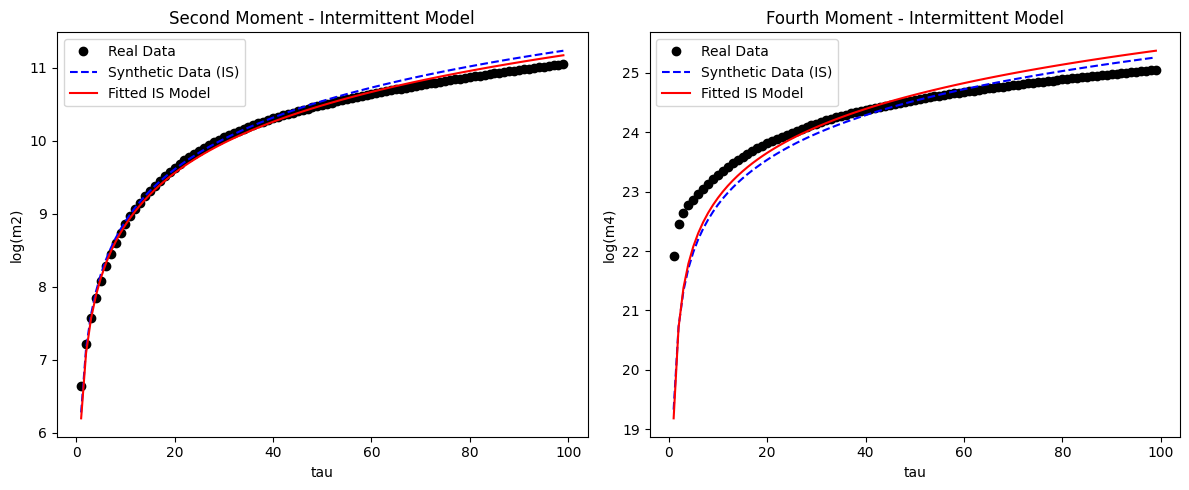

In [ ]:
import matplotlib.pyplot as plt

# Ensure lengths match
min_length = min(len(avg_real_m2), len(dx2_log_IS_synth), len(fitted_mom2_IS))
tau_list_plot = tau_list[:min_length]
avg_real_m2_plot = avg_real_m2[:min_length]
avg_real_m4_plot = avg_real_m4[:min_length]
dx2_log_IS_synth = dx2_log_IS_synth[:min_length]
dx4_log_IS_synth = dx4_log_IS_synth[:min_length]
fitted_mom2_IS = fitted_mom2_IS[:min_length]
fitted_mom4_IS = fitted_mom4_IS[:min_length]

# Plotting
plt.figure(figsize=(12, 5))

# Plotting M2
plt.subplot(1, 2, 1)
plt.plot(tau_list_plot, avg_real_m2_plot, 'o', color='black', label='Real Data')
plt.plot(tau_list_plot, dx2_log_IS_synth, '--', color='blue', label='Synthetic Data (IS)')
plt.plot(tau_list_plot, fitted_mom2_IS, '-', color='red', label='Fitted IS Model')
plt.xlabel('tau')
plt.ylabel('log(m2)')
plt.title('Second Moment - Intermittent Model')
plt.legend()

# Plotting M4
plt.subplot(1, 2, 2)
plt.plot(tau_list_plot, avg_real_m4_plot, 'o', color='black', label='Real Data')
plt.plot(tau_list_plot, dx4_log_IS_synth, '--', color='blue', label='Synthetic Data (IS)')
plt.plot(tau_list_plot, fitted_mom4_IS, '-', color='red', label='Fitted IS Model')
plt.xlabel('tau')
plt.ylabel('log(m4)')
plt.title('Fourth Moment - Intermittent Model')
plt.legend()

plt.tight_layout()import numpy as np
import matplotlib.pyplot as plt

# Load the saved data
levy_m2 = np.loadtxt('results/levy/lev_generated_logdx2_list.txt')
levy_m4 = np.loadtxt('results/levy/lev_generated_logdx4_list.txt')
intermittent_m2 = np.loadtxt('results/intermittent/int_generated_logdx2_list.txt')
intermittent_m4 = np.loadtxt('results/intermittent/int_generated_logdx4_list.txt')

levy_fit_m2 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt')
levy_fit_m4 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt')
intermittent_fit_m2 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt')
intermittent_fit_m4 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt')

# Define tau_list (assuming the same tau_list is used for all simulations)
tau_list = np.arange(1, 100)

# Calculate the average over iterations
avg_levy_m2 = np.mean(levy_m2, axis=0)
avg_levy_m4 = np.mean(levy_m4, axis=0)
avg_intermittent_m2 = np.mean(intermittent_m2, axis=0)
avg_intermittent_m4 = np.mean(intermittent_m4, axis=0)

avg_levy_fit_m2 = np.mean(levy_fit_m2, axis=0)
avg_levy_fit_m4 = np.mean(levy_fit_m4, axis=0)
avg_intermittent_fit_m2 = np.mean(intermittent_fit_m2, axis=0)
avg_intermittent_fit_m4 = np.mean(intermittent_fit_m4, axis=0)

# Create the unified plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Lévy moments
axes[0, 0].plot(tau_list, avg_levy_m2, 'o', color='orange', label='Synthetic')
axes[0, 0].plot(tau_list, avg_levy_fit_m2, '--', color='red', label='Lévy Model')
axes[0, 0].set_title("Lévy - Second Moment")
axes[0, 0].set_xlabel('$t_s$')
axes[0, 0].set_ylabel('$m_2(t_s)$')
axes[0, 0].legend()

axes[0, 1].plot(tau_list, avg_levy_m4, 'o', color='purple', label='Synthetic')
axes[0, 1].plot(tau_list, avg_levy_fit_m4, '--', color='green', label='Lévy Model')
axes[0, 1].set_title("Lévy - Fourth Moment")
axes[0, 1].set_xlabel('$t_s$')
axes[0, 1].set_ylabel('$m_4(t_s)$')
axes[0, 1].legend()

# Plot Intermittent moments
axes[1, 0].plot(tau_list, avg_intermittent_m2, 'o', color='blue', label='Synthetic')
axes[1, 0].plot(tau_list, avg_intermittent_fit_m2, '--', color='red', label='Intermittent Model')
axes[1, 0].set_title("Intermittent - Second Moment")
axes[1, 0].set_xlabel('$t_s$')
axes[1, 0].set_ylabel('$m_2(t_s)$')
axes[1, 0].legend()

axes[1, 1].plot(tau_list, avg_intermittent_m4, 'o', color='cyan', label='Synthetic')
axes[1, 1].plot(tau_list, avg_intermittent_fit_m4, '--', color='magenta', label='Intermittent Model')
axes[1, 1].set_title("Intermittent - Fourth Moment")
axes[1, 1].set_xlabel('$t_s$')
axes[1, 1].set_ylabel('$m_4(t_s)$')
axes[1, 1].legend()

# Adjust layout and save the plot
plt.tight_layout()
plt.show()

plt.show()


In [ ]:
from intermittent_levy.optimization import to_optimize_levy
from intermittent_levy.moments import levy_moments_log

def fit_levy_model(tau_list, dx2_log, dx4_log):
    alpha_est = 2.5
    v_mean_est = 10
    tmin_est = 0.01  # Set tmin as needed
    bounds_LW = [
        (1.1, 3.0),  # Alpha between 1.1 and 3
        (v_mean_est / 100, v_mean_est * 100)
    ]
    args_LW = (tau_list, dx2_log, dx4_log, tmin_est)
    result_LW = differential_evolution(
        to_optimize_levy,
        bounds=bounds_LW,
        args=args_LW,
        maxiter=1000,
        polish=True
    )
    optimized_alpha, optimized_v_mean = result_LW.x
    fitted_mom2_LW = levy_moments_log(2, optimized_alpha, optimized_v_mean, tau_list, tmin_est)
    fitted_mom4_LW = levy_moments_log(4, optimized_alpha, optimized_v_mean, tau_list, tmin_est)
    return (optimized_alpha, optimized_v_mean, tmin_est), fitted_mom2_LW, fitted_mom4_LW

optimized_params_LW, fitted_mom2_Limport numpy as np
import matplotlib.pyplot as plt

# Load the saved data
levy_m2 = np.loadtxt('results/levy/lev_generated_logdx2_list.txt')
levy_m4 = np.loadtxt('results/levy/lev_generated_logdx4_list.txt')
intermittent_m2 = np.loadtxt('results/intermittent/int_generated_logdx2_list.txt')
intermittent_m4 = np.loadtxt('results/intermittent/int_generated_logdx4_list.txt')

levy_fit_m2 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt')
levy_fit_m4 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt')
intermittent_fit_m2 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt')
intermittent_fit_m4 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt')

# Define tau_list (assuming the same tau_list is used for all simulations)
tau_list = np.arange(1, 100)

# Calculate the average over iterations
avg_levy_m2 = np.mean(levy_m2, axis=0)
avg_levy_m4 = np.mean(levy_m4, axis=0)
avg_intermittent_m2 = np.mean(intermittent_m2, axis=0)
avg_intermittent_m4 = np.mean(intermittent_m4, axis=0)

avg_levy_fit_m2 = np.mean(levy_fit_m2, axis=0)
avg_levy_fit_m4 = np.mean(levy_fit_m4, axis=0)
avg_intermittent_fit_m2 = np.mean(intermittent_fit_m2, axis=0)
avg_intermittent_fit_m4 = np.mean(intermittent_fit_m4, axis=0)

# Create the unified plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Lévy moments
axes[0, 0].plot(tau_list, avg_levy_m2, 'o', color='orange', label='Synthetic')
axes[0, 0].plot(tau_list, avg_levy_fit_m2, '--', color='red', label='Lévy Model')
axes[0, 0].set_title("Lévy - Second Moment")
axes[0, 0].set_xlabel('$t_s$')
axes[0, 0].set_ylabel('$m_2(t_s)$')
axes[0, 0].legend()

axes[0, 1].plot(tau_list, avg_levy_m4, 'o', color='purple', label='Synthetic')
axes[0, 1].plot(tau_list, avg_levy_fit_m4, '--', color='green', label='Lévy Model')
axes[0, 1].set_title("Lévy - Fourth Moment")
axes[0, 1].set_xlabel('$t_s$')
axes[0, 1].set_ylabel('$m_4(t_s)$')
axes[0, 1].legend()

# Plot Intermittent moments
axes[1, 0].plot(tau_list, avg_intermittent_m2, 'o', color='blue', label='Synthetic')
axes[1, 0].plot(tau_list, avg_intermittent_fit_m2, '--', color='red', label='Intermittent Model')
axes[1, 0].set_title("Intermittent - Second Moment")
axes[1, 0].set_xlabel('$t_s$')
axes[1, 0].set_ylabel('$m_2(t_s)$')
axes[1, 0].legend()

axes[1, 1].plot(tau_list, avg_intermittent_m4, 'o', color='cyan', label='Synthetic')
axes[1, 1].plot(tau_list, avg_intermittent_fit_m4, '--', color='magenta', label='Intermittent Model')
axes[1, 1].set_title("Intermittent - Fourth Moment")
axes[1, 1].set_xlabel('$t_s$')
axes[1, 1].set_ylabel('$m_4(t_s)$')
axes[1, 1].legend()

# Adjust layout and save the plot
plt.tight_layout()
plt.show()
W, fitted_mom4_LW = fit_levy_model(tau_list, avg_real_m2, avg_real_m4)

# Unpack the optimized parameters
alpha_opt, v_mean_opt, tmin_opt = optimized_params_LW


In [42]:
from intermittent_levy.processes import levy_flight_2D_Simplified

# Generate synthetic data using the optimized parameters
N = 300000  # Adjust as needed
max_range = 10000  # Adjust as needed
measuring_dt = 1  # Time step

xsynth_LW, ysynth_LW = levy_flight_2D_Simplified(N, max_range, alpha_opt, tmin_opt, v_mean_opt, measuring_dt)


In [43]:
dx2_log_LW_synth, dx4_log_LW_synth = calculate_moments(xsynth_LW, ysynth_LW, tau_list)


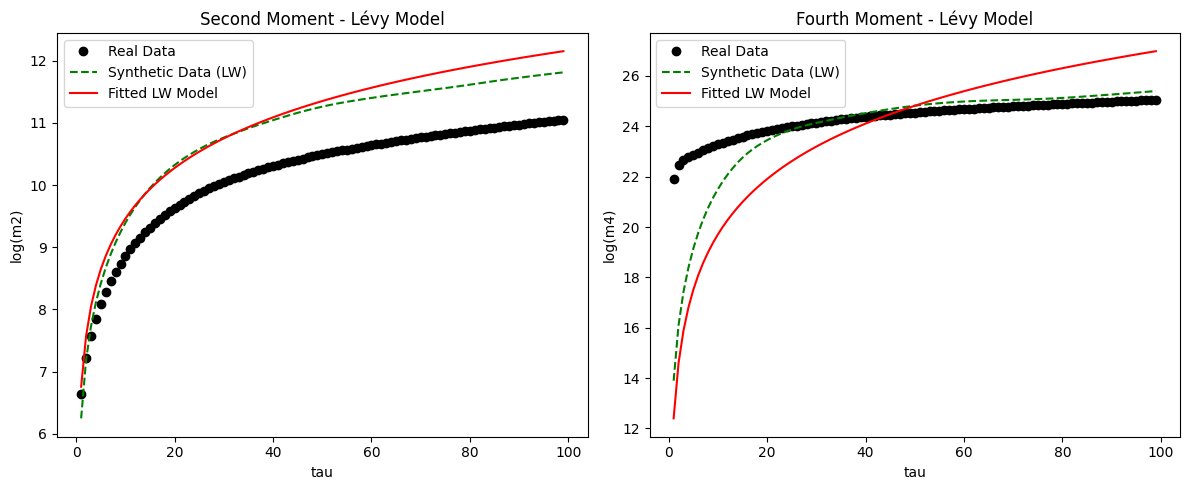

In [44]:
# Ensure lengths match
min_length = min(len(avg_real_m2), len(dx2_log_LW_synth), len(fitted_mom2_LW))
tau_list_plot = tau_list[:min_length]
avg_real_m2_plot = avg_real_m2[:min_length]
avg_real_m4_plot = avg_real_m4[:min_length]
dx2_log_LW_synth = dx2_log_LW_synth[:min_length]
dx4_log_LW_synth = dx4_log_LW_synth[:min_length]
fitted_mom2_LW = fitted_mom2_LW[:min_length]
fitted_mom4_LW = fitted_mom4_LW[:min_length]

# Plotting
plt.figure(figsize=(12, 5))

# Plotting M2
plt.subplot(1, 2, 1)
plt.plot(tau_list_plot, avg_real_m2_plot, 'o', color='black', label='Real Data')
plt.plot(tau_list_plot, dx2_log_LW_synth, '--', color='green', label='Synthetic Data (LW)')
plt.plot(tau_list_plot, fitted_mom2_LW, '-', color='red', label='Fitted LW Model')
plt.xlabel('tau')
plt.ylabel('log(m2)')
plt.title('Second Moment - Lévy Model')
plt.legend()

# Plotting M4
plt.subplot(1, 2, 2)
plt.plot(tau_list_plot, avg_real_m4_plot, 'o', color='black', label='Real Data')
plt.plot(tau_list_plot, dx4_log_LW_synth, '--', color='green', label='Synthetic Data (LW)')
plt.plot(tau_list_plot, fitted_mom4_LW, '-', color='red', label='Fitted LW Model')
plt.xlabel('tau')
plt.ylabel('log(m4)')
plt.title('Fourth Moment - Lévy Model')
plt.legend()

plt.tight_layout()
plt.show()


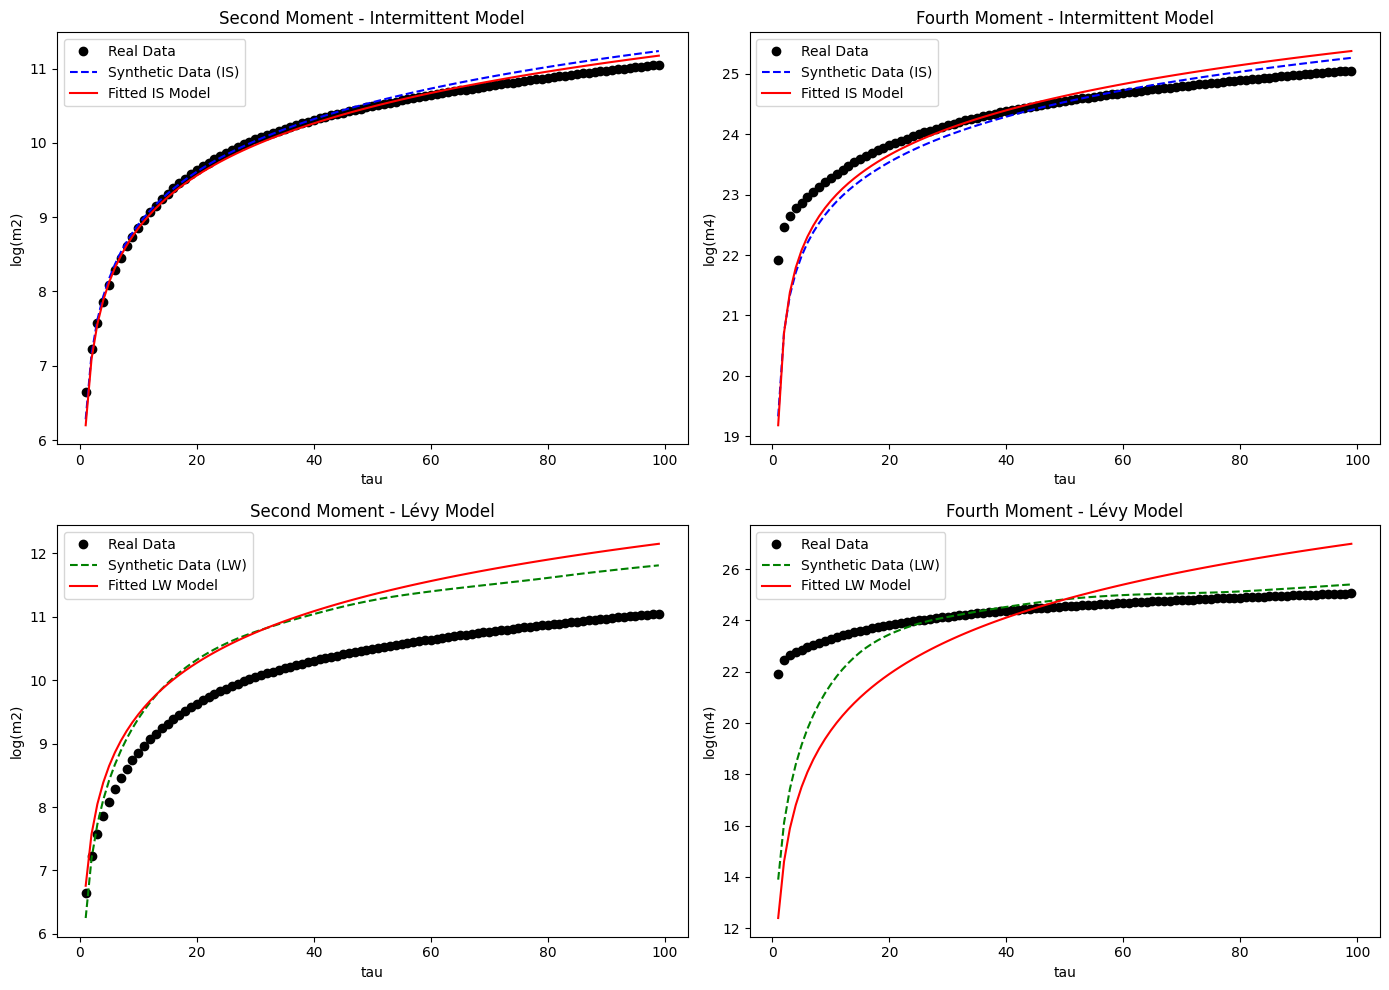

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Intermittent Model - Second Moment
axes[0, 0].plot(tau_list_plot, avg_real_m2_plot, 'o', color='black', label='Real Data')
axes[0, 0].plot(tau_list_plot, dx2_log_IS_synth, '--', color='blue', label='Synthetic Data (IS)')
axes[0, 0].plot(tau_list_plot, fitted_mom2_IS, '-', color='red', label='Fitted IS Model')
axes[0, 0].set_title('Second Moment - Intermittent Model')
axes[0, 0].set_xlabel('tau')
axes[0, 0].set_ylabel('log(m2)')
axes[0, 0].legend()

# Intermittent Model - Fourth Moment
axes[0, 1].plot(tau_list_plot, avg_real_m4_plot, 'o', color='black', label='Real Data')
axes[0, 1].plot(tau_list_plot, dx4_log_IS_synth, '--', color='blue', label='Synthetic Data (IS)')
axes[0, 1].plot(tau_list_plot, fitted_mom4_IS, '-', color='red', label='Fitted IS Model')
axes[0, 1].set_title('Fourth Moment - Intermittent Model')
axes[0, 1].set_xlabel('tau')
axes[0, 1].set_ylabel('log(m4)')
axes[0, 1].legend()

# Lévy Model - Second Moment
axes[1, 0].plot(tau_list_plot, avg_real_m2_plot, 'o', color='black', label='Real Data')
axes[1, 0].plot(tau_list_plot, dx2_log_LW_synth, '--', color='green', label='Synthetic Data (LW)')
axes[1, 0].plot(tau_list_plot, fitted_mom2_LW, '-', color='red', label='Fitted LW Model')
axes[1, 0].set_title('Second Moment - Lévy Model')
axes[1, 0].set_xlabel('tau')
axes[1, 0].set_ylabel('log(m2)')
axes[1, 0].legend()

# Lévy Model - Fourth Moment
axes[1, 1].plot(tau_list_plot, avg_real_m4_plot, 'o', color='black', label='Real Data')
axes[1, 1].plot(tau_list_plot, dx4_log_LW_synth, '--', color='green', label='Synthetic Data (LW)')
axes[1, 1].plot(tau_list_plot, fitted_mom4_LW, '-', color='red', label='Fitted LW Model')
axes[1, 1].set_title('Fourth Moment - Lévy Model')
axes[1, 1].set_xlabel('tau')
axes[1, 1].set_ylabel('log(m4)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved data
levy_m2 = np.loadtxt('results/levy/lev_generated_logdx2_list.txt')
levy_m4 = np.loadtxt('results/levy/lev_generated_logdx4_list.txt')
intermittent_m2 = np.loadtxt('results/intermittent/int_generated_logdx2_list.txt')
intermittent_m4 = np.loadtxt('results/intermittent/int_generated_logdx4_list.txt')

levy_fit_m2 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt')
levy_fit_m4 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt')
intermittent_fit_m2 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt')
intermittent_fit_m4 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt')

# Define tau_list (assuming the same tau_list is used for all simulations)
tau_list = np.arange(1, 100)

# Calculate the average over iterations
avg_levy_m2 = np.mean(levy_m2, axis=0)
avg_levy_m4 = np.mean(levy_m4, axis=0)
avg_intermittent_m2 = np.mean(intermittent_m2, axis=0)
avg_intermittent_m4 = np.mean(intermittent_m4, axis=0)

avg_levy_fit_m2 = np.mean(levy_fit_m2, axis=0)
avg_levy_fit_m4 = np.mean(levy_fit_m4, axis=0)
avg_intermittent_fit_m2 = np.mean(intermittent_fit_m2, axis=0)
avg_intermittent_fit_m4 = np.mean(intermittent_fit_m4, axis=0)

# Create the unified plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Lévy moments
axes[0, 0].plot(tau_list, avg_levy_m2, 'o', color='orange', label='Synthetic')
axes[0, 0].plot(tau_list, avg_levy_fit_m2, '--', color='red', label='Lévy Model')
axes[0, 0].set_title("Lévy - Second Moment")
axes[0, 0].set_xlabel('$t_s$')
axes[0, 0].set_ylabel('$m_2(t_s)$')
axes[0, 0].legend()

axes[0, 1].plot(tau_list, avg_levy_m4, 'o', color='purple', label='Synthetic')
axes[0, 1].plot(tau_list, avg_levy_fit_m4, '--', color='green', label='Lévy Model')
axes[0, 1].set_title("Lévy - Fourth Moment")
axes[0, 1].set_xlabel('$t_s$')
axes[0, 1].set_ylabel('$m_4(t_s)$')
axes[0, 1].legend()

# Plot Intermittent moments
axes[1, 0].plot(tau_list, avg_intermittent_m2, 'o', color='blue', label='Synthetic')
axes[1, 0].plot(tau_list, avg_intermittent_fit_m2, '--', color='red', label='Intermittent Model')
axes[1, 0].set_title("Intermittent - Second Moment")
axes[1, 0].set_xlabel('$t_s$')
axes[1, 0].set_ylabel('$m_2(t_s)$')
axes[1, 0].legend()

axes[1, 1].plot(tau_list, avg_intermittent_m4, 'o', color='cyan', label='Synthetic')
axes[1, 1].plot(tau_list, avg_intermittent_fit_m4, '--', color='magenta', label='Intermittent Model')
axes[1, 1].set_title("Intermittent - Fourth Moment")
axes[1, 1].set_xlabel('$t_s$')
axes[1, 1].set_ylabel('$m_4(t_s)$')
axes[1, 1].legend()

# Adjust layout and save the plot
plt.tight_layout()
plt.show()


# Fourth Method

# Step 1: Load and Preprocess Your Real Data

In [48]:
import numpy as np
import os

def load_eye_tracking_data(folder_path, file_extension='Waldo_Ruj1.txt', remove_first_n_points=250):
    files = [file for file in os.listdir(folder_path) if file.endswith(file_extension)]
    if not files:
        raise FileNotFoundError(f"No files found with extension '{file_extension}' in '{folder_path}'.")
    T, X, Y, saccade = [], [], [], []
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = np.loadtxt(file_path)
        if data.shape[0] > data.shape[1]:
            data = data.T
        T_i = data[0][remove_first_n_points:]
        X_i = data[1][remove_first_n_points:]
        Y_i = data[2][remove_first_n_points:]
        saccade_i = data[3][remove_first_n_points:]
        T.append(T_i)
        X.append(X_i)
        Y.append(Y_i)
        saccade.append(saccade_i)
    return {"T": T, "X": X, "Y": Y, "saccade": saccade}

# Example usage:
folder_path = '/home/shailendra/Documents/PhD_Oslomet/QuantumGanWaldo/WALDO/WalDo'
result = load_eye_tracking_data(folder_path)


# Step 2: Calculate Empirical Moments


In [49]:
def calculate_real_moments(real_data, tau_list):
    dx2_log_list = []
    dx4_log_list = []
    for X, Y in zip(real_data['X'], real_data['Y']):
        X, Y = np.array(X), np.array(Y)
        valid_indices = np.isfinite(X) & np.isfinite(Y)
        X, Y = X[valid_indices], Y[valid_indices]
        if len(X) < max(tau_list) + 1:
            continue
        dx2 = []
        dx4 = []
        for tau in tau_list:
            dt = int(tau)
            if len(X) < dt + 1:
                break
            dx = X[dt:] - X[:-dt]
            dy = Y[dt:] - Y[:-dt]
            displacement = dx**2 + dy**2
            displacement = displacement[displacement > 0]
            if len(displacement) == 0:
                dx2.append(np.nan)
                dx4.append(np.nan)
                continue
            dx2.append(np.mean(displacement))
            dx4.append(np.mean(displacement**2))
        dx2 = np.array(dx2)
        dx4 = np.array(dx4)
        dx2_log = np.log(dx2[~np.isnan(dx2)])
        dx4_log = np.log(dx4[~np.isnan(dx4)])
        dx2_log_list.append(dx2_log)
        dx4_log_list.append(dx4_log)
    return {'log_M2': np.array(dx2_log_list), 'log_M4': np.array(dx4_log_list)}

tau_list = np.arange(1, 100)
real_moments = calculate_real_moments(real_data, tau_list)

# Calculate average moments
avg_real_m2 = np.nanmean(real_moments['log_M2'], axis=0)
avg_real_m4 = np.nanmean(real_moments['log_M4'], axis=0)


# Step 3: Fit the Intermittent Search and Lévy Walk Models

In [52]:
from intermittent_levy.optimization import to_optimize_mom4_and_2_serg_log
from intermittent_levy.moments import mom2_serg_log, mom4_serg_log
from scipy.optimize import differential_evolution

def fit_intermittent_model(tau_list, dx2_log, dx4_log):
    # Initial parameter estimates
    v0_est = 10
    D_est = 1
    lambda_B_est = 0.1
    lambda_D_est = 0.05
    # Define bounds
    bounds_IS = [
        (v0_est / 100, v0_est * 100),
        (D_est / 100, D_est * 100),
        (lambda_B_est / 100, lambda_B_est * 100),
        (lambda_D_est / 100, lambda_D_est * 100)
    ]
    args_IS = (tau_list, dx2_log, dx4_log)
    # Optimize
    result_IS = differential_evolution(
        to_optimize_mom4_and_2_serg_log,
        bounds=bounds_IS,
        args=args_IS,
        maxiter=1000,
        polish=True
    )
    optimized_params_IS = result_IS.x
    # Compute fitted moments
    fitted_mom2_IS = mom2_serg_log(tau_list, *optimized_params_IS)
    fitted_mom4_IS = mom4_serg_log(tau_list, *optimized_params_IS)
    return optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS

optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS = fit_intermittent_model(tau_list, avg_real_m2, avg_real_m4)

from intermittent_levy.optimization import to_optimize_levy
from intermittent_levy.moments import levy_moments_log

def fit_levy_model(tau_list, dx2_log, dx4_log):
    alpha_est = 2.5
    v_mean_est = 10
    tmin_est = 0.01  # Adjust as necessary
    bounds_LW = [
        (1.1, 3.0),  # Alpha between 1.1 and 3
        (v_mean_est / 100, v_mean_est * 100)
    ]
    args_LW = (tau_list, dx2_log, dx4_log, tmin_est)
    result_LW = differential_evolution(
        to_optimize_levy,
        bounds=bounds_LW,
        args=args_LW,
        maxiter=1000,
        polish=True
    )
    optimized_alpha, optimized_v_mean = result_LW.x
    # Compute fitted moments
    fitted_mom2_LW = levy_moments_log(2, optimized_alpha, optimized_v_mean, tau_list, tmin_est)
    fitted_mom4_LW = levy_moments_log(4, optimized_alpha, optimized_v_mean, tau_list, tmin_est)
    return (optimized_alpha, optimized_v_mean, tmin_est), fitted_mom2_LW, fitted_mom4_LW

optimized_params_LW, fitted_mom2_LW, fitted_mom4_LW = fit_levy_model(tau_list, avg_real_m2, avg_real_m4)



# Step 4: Calculate Goodness-of-Fit Metrics


In [ ]:
from intermittent_levy.utils import adjusted_r_squareimport matplotlib.pyplot as plt

# Ensure lengths match
min_length = min(len(avg_real_m2), len(fitted_mom2_IS), len(fitted_mom2_LW))
tau_list_plot = tau_list[:min_length]
avg_real_m2_plot = avg_real_m2[:min_length]
avg_real_m4_plot = avg_real_m4[:min_length]
fitted_mom2_IS = fitted_mom2_IS[:min_length]
fitted_mom4_IS = fitted_mom4_IS[:min_length]
fitted_mom2_LW = fitted_mom2_LW[:min_length]
fitted_mom4_LW = fitted_mom4_LW[:min_length]

# Plotting
plt.figure(figsize=(14, 6))

# Plotting M2
plt.subplot(1, 2, 1)
plt.plot(tau_list_plot, avg_real_m2_plot, 'o', color='black', label='Real Data')
plt.plot(tau_list_plot, fitted_mom2_IS, '-', color='blue', label='Fitted IS Model')
plt.plot(tau_list_plot, fitted_mom2_LW, '--', color='red', label='Fitted LW Model')
plt.xlabel('tau')
plt.ylabel('log(m2)')
plt.title('Second Moment')
plt.legend()

# Plotting M4
plt.subplot(1, 2, 2)
plt.plot(tau_list_plot, avg_real_m4_plot, 'o', color='black', label='Real Data')
plt.plot(tau_list_plot, fitted_mom4_IS, '-', color='blue', label='Fitted IS Model')
plt.plot(tau_list_plot, fitted_mom4_LW, '--', color='red', label='Fitted LW Model')
plt.xlabel('tau')
plt.ylabel('log(m4)')
plt.title('Fourth Moment')
plt.legend()

plt.tight_layout()
plt.show()

r2_mom4_LW = adjusted_r_square(avg_real_m4, fitted_mom4_LW, degrees_freedom=3)
R2_adj_LW = (r2_mom2_LW + r2_mom4_LW) / 2


# Step 5: Classify Each Trajectory


In [54]:
if R2_adj_IS > R2_adj_LW:
    print("Intermittent Search (IS) model fits the data better.")
    best_model = 'IS'
    best_params = optimized_params_IS
else:
    print("Lévy Walk (LW) model fits the data better.")
    best_model = 'LW'
    best_params = optimized_params_LW


Intermittent Search (IS) model fits the data better.


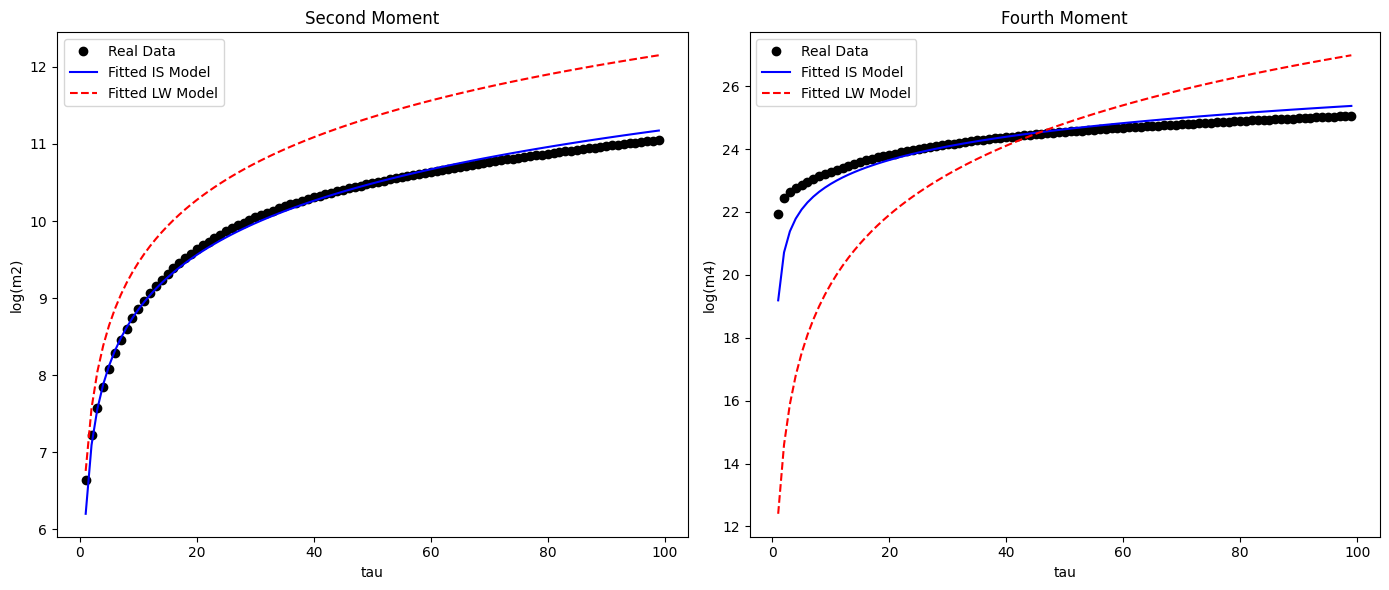

In [55]:
import matplotlib.pyplot as plt

# Ensure lengths match
min_length = min(len(avg_real_m2), len(fitted_mom2_IS), len(fitted_mom2_LW))
tau_list_plot = tau_list[:min_length]
avg_real_m2_plot = avg_real_m2[:min_length]
avg_real_m4_plot = avg_real_m4[:min_length]
fitted_mom2_IS = fitted_mom2_IS[:min_length]
fitted_mom4_IS = fitted_mom4_IS[:min_length]
fitted_mom2_LW = fitted_mom2_LW[:min_length]
fitted_mom4_LW = fitted_mom4_LW[:min_length]

# Plotting
plt.figure(figsize=(14, 6))

# Plotting M2
plt.subplot(1, 2, 1)
plt.plot(tau_list_plot, avg_real_m2_plot, 'o', color='black', label='Real Data')
plt.plot(tau_list_plot, fitted_mom2_IS, '-', color='blue', label='Fitted IS Model')
plt.plot(tau_list_plot, fitted_mom2_LW, '--', color='red', label='Fitted LW Model')
plt.xlabel('tau')
plt.ylabel('log(m2)')
plt.title('Second Moment')
plt.legend()

# Plotting M4
plt.subplot(1, 2, 2)
plt.plot(tau_list_plot, avg_real_m4_plot, 'o', color='black', label='Real Data')
plt.plot(tau_list_plot, fitted_mom4_IS, '-', color='blue', label='Fitted IS Model')
plt.plot(tau_list_plot, fitted_mom4_LW, '--', color='red', label='Fitted LW Model')
plt.xlabel('tau')
plt.ylabel('log(m4)')
plt.title('Fourth Moment')
plt.legend()

plt.tight_layout()
plt.show()


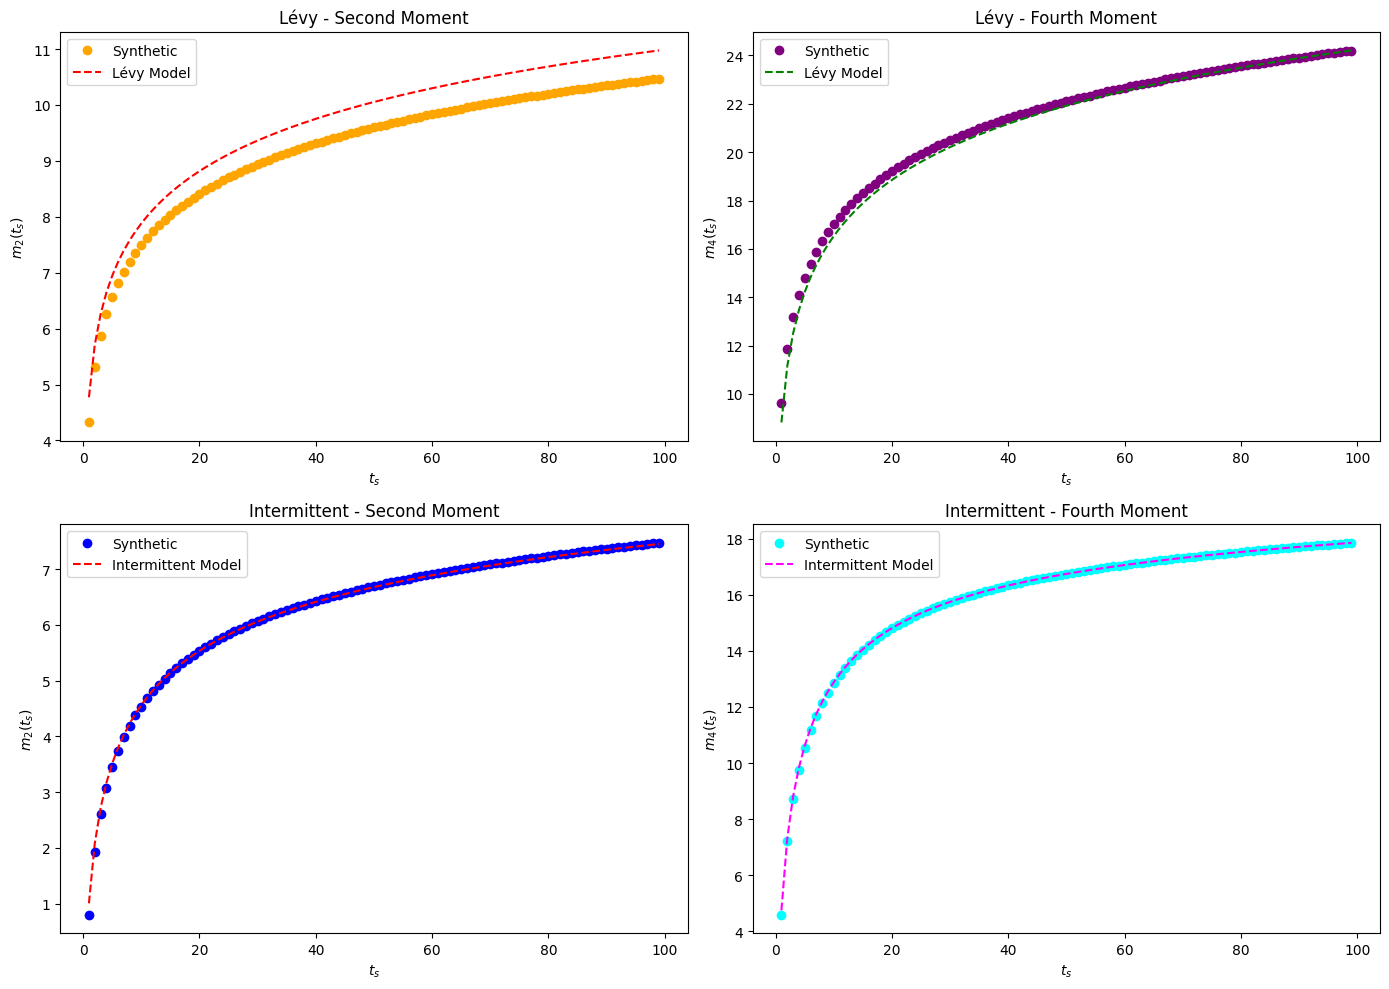

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved data
levy_m2 = np.loadtxt('results/levy/lev_generated_logdx2_list.txt')
levy_m4 = np.loadtxt('results/levy/lev_generated_logdx4_list.txt')
intermittent_m2 = np.loadtxt('results/intermittent/int_generated_logdx2_list.txt')
intermittent_m4 = np.loadtxt('results/intermittent/int_generated_logdx4_list.txt')

levy_fit_m2 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt')
levy_fit_m4 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt')
intermittent_fit_m2 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt')
intermittent_fit_m4 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt')

# Define tau_list (assuming the same tau_list is used for all simulations)
tau_list = np.arange(1, 100)

# Calculate the average over iterations
avg_levy_m2 = np.mean(levy_m2, axis=0)
avg_levy_m4 = np.mean(levy_m4, axis=0)
avg_intermittent_m2 = np.mean(intermittent_m2, axis=0)
avg_intermittent_m4 = np.mean(intermittent_m4, axis=0)

avg_levy_fit_m2 = np.mean(levy_fit_m2, axis=0)
avg_levy_fit_m4 = np.mean(levy_fit_m4, axis=0)
avg_intermittent_fit_m2 = np.mean(intermittent_fit_m2, axis=0)
avg_intermittent_fit_m4 = np.mean(intermittent_fit_m4, axis=0)

# Create the unified plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Lévy moments
axes[0, 0].plot(tau_list, avg_levy_m2, 'o', color='orange', label='Synthetic')
axes[0, 0].plot(tau_list, avg_levy_fit_m2, '--', color='red', label='Lévy Model')
axes[0, 0].set_title("Lévy - Second Moment")
axes[0, 0].set_xlabel('$t_s$')
axes[0, 0].set_ylabel('$m_2(t_s)$')
axes[0, 0].legend()

axes[0, 1].plot(tau_list, avg_levy_m4, 'o', color='purple', label='Synthetic')
axes[0, 1].plot(tau_list, avg_levy_fit_m4, '--', color='green', label='Lévy Model')
axes[0, 1].set_title("Lévy - Fourth Moment")
axes[0, 1].set_xlabel('$t_s$')
axes[0, 1].set_ylabel('$m_4(t_s)$')
axes[0, 1].legend()

# Plot Intermittent moments
axes[1, 0].plot(tau_list, avg_intermittent_m2, 'o', color='blue', label='Synthetic')
axes[1, 0].plot(tau_list, avg_intermittent_fit_m2, '--', color='red', label='Intermittent Model')
axes[1, 0].set_title("Intermittent - Second Moment")
axes[1, 0].set_xlabel('$t_s$')
axes[1, 0].set_ylabel('$m_2(t_s)$')
axes[1, 0].legend()

axes[1, 1].plot(tau_list, avg_intermittent_m4, 'o', color='cyan', label='Synthetic')
axes[1, 1].plot(tau_list, avg_intermittent_fit_m4, '--', color='magenta', label='Intermittent Model')
axes[1, 1].set_title("Intermittent - Fourth Moment")
axes[1, 1].set_xlabel('$t_s$')
axes[1, 1].set_ylabel('$m_4(t_s)$')
axes[1, 1].legend()

# Adjust layout and save the plot
plt.tight_layout()
plt.show()
